In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.deprecation import deprecated

import os
import csv
import copy
import math
import time
import random
import pickle
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from collections import Counter
from statsmodels.tools.eval_measures import mse
from statsmodels.stats.multitest import fdrcorrection
from decimal import Decimal
from scipy import stats
from scipy.stats import spearmanr, rankdata, norm, fisher_exact
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# MR analysis for one disease

In [2]:
# find all allen regions
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_8_or_less/Prediction/300_500_by_subject/'
filename = 'GTEX-1192X_300_500_trainable_LMfromGTEx.csv'
df = pd.read_csv(save_dir+filename, index_col=0)
keys = df.columns

# read all 15028 genes (chrY genes not included)
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_for_allen_regions/fastqtl_results/'
filename = '13005' + '.genes.txt.gz'
our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

# read the ensg to gene id table
data_dir = '/project/pi_rachel_melamed_uml_edu/adni/data/'
filename = 'ensg2gene_name.txt'
column_names = ['gene_id', 'gene_name']
ensg2gene = pd.read_csv(data_dir+filename, delimiter='\t')
ensg2gene.columns = column_names

# which dataset here
dataset = 'ieu-b-42'

In [3]:
# import subprocess
# import os
# # run the batch for each region
# dataset = 'ieu-b-42'
# save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
# for region in keys:
    
#     # double check if any missing running
#     filename1 = f"{region}_{dataset}_mr_results_method1_API.csv"
#     file_path1 = os.path.join(save_dir, filename1)
#     # Check if the file already exists
#     if os.path.exists(file_path1):
#         print(f"File {file_path1} already exists, skipping.")
#     else:
#         command = f'sbatch /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/mr_analysis_method1_API_single.sh {region} {dataset}'
#         subprocess.run(command, shell=True)
#         print(f"Running command for {region}")
        
#     # method 2
#     filename2 = f"{region}_{dataset}_mr_results_method1_local.csv"
#     file_path2 = os.path.join(save_dir, filename2)
#     if os.path.exists(file_path2):
#         print(f"File {file_path2} already exists, skipping.")
#     else:
#         command = f'sbatch /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/mr_analysis_method1_local_single.sh {region} {dataset}'
#         subprocess.run(command, shell=True)
#         print(f"Running command for {region}")
        
#     # method 3
#     filename3 = f"{region}_{dataset}_mr_results_method2_local.csv"
#     file_path3 = os.path.join(save_dir, filename3)
#     if os.path.exists(file_path3):
#         print(f"File {file_path3} already exists, skipping.")
#     else:
#         command = f'sbatch /project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/mr_analysis_method2_local_single.sh {region} {dataset}'
#         subprocess.run(command, shell=True)
#         print(f"Running command for {region}")

## MR analysis with method 1 API

### Bonferroni correction

#### analysis by gene

In [4]:
# # read the mr results for 103 regions into a dictionary
# mr_result_dir = {}
# for region in keys:
#     save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
#     filename = f"{region}_{dataset}_mr_results.csv"
#     mr_result = pd.read_csv(save_dir+filename)
#     mr_result_dir[region] = mr_result

# # find the number of eqtls that are significant in MR for each allen region by gene
# all_gene_ids = set()
# for key, df in mr_result_dir.items():
#     all_gene_ids.update(df['gene_id'].unique())
# all_gene_ids = sorted(all_gene_ids)
# # map the ensg_id to gene_name
# mat = pd.DataFrame({'gene_id': all_gene_ids})
# merged_df = pd.merge(mat, ensg2gene, on='gene_id', how='left')
# gene_name_list = merged_df['gene_name']
# # Create a DataFrame filled with zeros
# mr_result_by_gene = pd.DataFrame(np.zeros((len(gene_name_list), len(keys)), dtype=int), index=gene_name_list, columns=keys)
# pval_threshold = 0.05/103/mr_result_by_gene.shape[0]
# print(f"There are {mr_result_by_gene.shape[0]} unique snps across 103 allen regions")
# print(f"The corresponding pval threshold is {pval_threshold}!")

# # iterate over the dictionary
# for region in keys:
#     mr_result_mat = mr_result_dir[region]
#     # find the gene name
#     merged_df = pd.merge(mr_result_mat, ensg2gene, on='gene_id', how='left')
#     sig_merged_df = merged_df[merged_df['mr_p']<pval_threshold]
#     uni_gene_list = list(set(sig_merged_df['gene_name']))
#     for gene in uni_gene_list:
#         sub_mat = merged_df[merged_df['gene_name']==gene]
#         mr_result_by_gene[region][gene] = len(sub_mat)

In [5]:
# no_zero_mat = mr_result_by_gene.copy()
# print(f'There are {np.sum(no_zero_mat.values)} significant snps passed MR analysis')
# no_zero_mat = no_zero_mat.loc[~(no_zero_mat == 0).all(axis=1)]
# no_zero_mat = no_zero_mat.loc[:, ~(no_zero_mat == 0).all(axis=0)]
# no_zero_mat

#### analysis by snp

In [6]:
# find the pval threshold
# snps that have both eqtl and gwas data across all regions
mr_input_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_inputs/"
    filename = f"{region}_{dataset}_eqtl_gwas_method1_API.csv"
    mr_input_mat = pd.read_csv(save_dir+filename)
    mr_input_dir[region] = mr_input_mat
    
# find the bonferroni corrected pval threshold
all_snps_w_eqtl_gwas = set()
for key, df in mr_input_dir.items():
    all_snps_w_eqtl_gwas.update(zip(df['gene_id'], df['rsid']))
all_snps_w_eqtl_gwas = sorted(all_snps_w_eqtl_gwas)
# snps that have both eqtl and gwas data across all regions for one disease
save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/mr_results/"
filename = save_dir+f"{dataset}_all_snps_w_eqtl_gwas_method1_API.pkl"
with open(filename, 'wb') as f:
    pickle.dump(all_snps_w_eqtl_gwas, f)
    
# the Bonferroni corrected pval threshold
bc_pval_threshold = 0.05/103/len(all_snps_w_eqtl_gwas)
print(f"There are {len(all_snps_w_eqtl_gwas)} unique snps across 103 allen regions.")
print(f"The Bonferroni corrected pval threshold is {bc_pval_threshold}!")

There are 12236 unique snps across 103 allen regions.
The Bonferroni corrected pval threshold is 3.967284187674759e-08!


In [7]:
# read the mr results for 103 regions into a dictionary
mr_result_method1_API_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
    filename = f"{region}_{dataset}_mr_results_method1_API.csv"
    mr_result = pd.read_csv(save_dir+filename)
    mr_result_method1_API_dir[region] = mr_result

all_gene_rsid_pairs = set()
for key, df in mr_result_method1_API_dir.items():
    all_gene_rsid_pairs.update(zip(df['gene_id'], df['rsid']))
all_gene_rsid_pairs = sorted(all_gene_rsid_pairs)
df_gene_rsid = pd.DataFrame(list(all_gene_rsid_pairs), columns=['gene_id', 'rsid'])
df_gene_rsid = pd.merge(df_gene_rsid, ensg2gene, on='gene_id', how='left')

gene_name_list = df_gene_rsid['gene_name']
rsid_list = df_gene_rsid['rsid']  # Assuming you have a column 'rsid' in merged_df
# Create a multi-index using 'gene_name' and 'rsid'
index = pd.MultiIndex.from_arrays([gene_name_list, rsid_list], names=['gene_name', 'rsid'])
# Create the DataFrame using the multi-index
mr_result_method1_API_by_rsid = pd.DataFrame(np.zeros((len(gene_name_list), len(keys)), dtype=int), index=index, columns=keys)

# iterate over the dictionary
for region in keys:
    mr_result_mat = mr_result_method1_API_dir[region]
    # find the gene name
    merged_df = pd.merge(mr_result_mat, ensg2gene, on='gene_id', how='left')
    sig_merged_df = merged_df[merged_df['mr_p']<bc_pval_threshold]
    uni_gene_list = list(set(sig_merged_df['gene_name']))
    for gene in uni_gene_list:
        sub_mat = sig_merged_df[sig_merged_df['gene_name']==gene]
        rsid_list = sub_mat['rsid']
        for rsid in rsid_list:
            mr_result_method1_API_by_rsid[region][gene, rsid] = 1

In [8]:
mr_bfc_method1_API = mr_result_method1_API_by_rsid.copy()
print(f'There are {np.sum(mr_bfc_method1_API.values)} significant snps passed MR analysis')
mr_bfc_method1_API = mr_bfc_method1_API.loc[~(mr_bfc_method1_API == 0).all(axis=1)]
mr_bfc_method1_API = mr_bfc_method1_API.loc[:, ~(mr_bfc_method1_API == 0).all(axis=0)]
print(f"There are {mr_bfc_method1_API.index.get_level_values('gene_name').nunique()} unique genes")
print(f"There are {mr_bfc_method1_API.index.get_level_values('rsid').nunique()} unique rsids")
mr_bfc_method1_API

There are 239 significant snps passed MR analysis
There are 13 unique genes
There are 32 unique rsids


4012  4013  4014  4023  4024  4030  4031  4039  4045  \
gene_name rsid                                                               
PCCB      rs10935184     0     0     0     0     0     0     0     0     0   
          rs526574       0     0     0     0     0     0     0     0     0   
          rs6764567      0     0     0     0     0     0     0     0     0   
          rs696081       0     0     0     0     0     0     0     0     0   
          rs73226190     0     0     0     0     0     0     0     0     0   
          rs834304       1     1     0     1     1     1     1     1     1   
CHRNA2    rs11783093     0     0     0     0     0     0     0     0     0   
CNNM2     rs4409766      0     0     0     0     0     0     0     0     0   
          rs77335224     0     0     0     0     0     0     0     0     0   
          rs7912206      0     0     0     0     0     0     0     0     0   
CACNA1C   rs12311439     0     0     0     0     0     0     0     0     0   
THOC7     rs3774720      0     0     0     0     0     0     0     0     0   
          rs56293138     0     0     1     0     0     0     0     0     0   
          rs6809474      0     0     0     0     0     0     0     0     0   
          rs704367       0     0     0     0     0     0     0     0     0   
          rs7615475      1     1     0     1     1     1     1     1     1   
GNL3      rs2336147      0     0     0     0     1     0     0     0     0   
          rs35212380     0     0     1     0     0     0     0     0     0   
WDR73     rs17601029     0     0     0     0     0     0     0     0     0   
          rs35630683     0     0     0     0     0     0     0     0     0   
          rs35738019     0     0     0     0     0     0     0     0     0   
BTN3A2    rs9379780      0     0     0     0     0     0     0     0     0   
          rs9393703      0     0     0     0     0     0     0     0     0   
ZSCAN23   rs6926470      0     0     0     0     0     0     0     0     0   
HLA-DMA   rs73409631     0     0     0     0     0     0     0     0     0   
AS3MT     rs11191419     0     0     0     0     0     0     0     0     0   
          rs12244388     0     0     0     0     0     0     0     0     0   
          rs12414777     1     1     1     1     1     1     1     1     1   
          rs4919691      0     0     0     0     0     0     0     0     0   
HLA-DQB2  rs1064991      0     0     0     0     0     0     0     0     0   
APOPT1    rs12884809     0     0     0     0     0     0     0     0     0   
          rs12890837     0     0     0     0     0     0     0     0     0   

                      4048  ...  9161  9492  9520  9543  9561  9598  9614  \
gene_name rsid              ...                                             
PCCB      rs10935184     0  ...     0     0     0     0     0     0     0   
          rs526574       0  ...     0     0     0     0     0     0     0   
          rs6764567      0  ...     1     1     1     1     1     1     1   
          rs696081       0  ...     0     0     0     0     0     0     0   
          rs73226190     0  ...     0     0     0     0     0     0     0   
          rs834304       1  ...     0     0     0     0     0     0     0   
CHRNA2    rs11783093     0  ...     0     0     0     0     0     0     0   
CNNM2     rs4409766      0  ...     0     1     0     0     0     0     0   
          rs77335224     0  ...     0     0     0     0     0     0     0   
          rs7912206      0  ...     0     0     0     0     0     0     0   
CACNA1C   rs12311439     0  ...     0     0     0     0     0     0     0   
THOC7     rs3774720      0  ...     0     0     0     0     0     0     0   
          rs56293138     0  ...     0     0     0     0     0     0     0   
          rs6809474      0  ...     1     1     0     0     0     0     0   
          rs704367       0  ...     0     0     0     0     0     0     0   
          rs7615475      1  ...     0     0     0     0     

### FDR correction

In [9]:
# read the mr results for 103 regions into a dictionary
mr_result_method1_API_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
    filename = f"{region}_{dataset}_mr_results_method1_API.csv"
    mr_result = pd.read_csv(save_dir+filename)
    mr_result_method1_API_dir[region] = mr_result
    
all_gene_rsid_pairs = set()
for key, df in mr_result_method1_API_dir.items():
    all_gene_rsid_pairs.update(zip(df['gene_id'], df['rsid']))
all_gene_rsid_pairs = sorted(all_gene_rsid_pairs)
df_gene_rsid = pd.DataFrame(list(all_gene_rsid_pairs), columns=['gene_id', 'rsid'])
df_gene_rsid = pd.merge(df_gene_rsid, ensg2gene, on='gene_id', how='left')
    
gene_name_list = df_gene_rsid['gene_name']
rsid_list = df_gene_rsid['rsid']
# Create a multi-index using 'gene_name' and 'rsid'
index = pd.MultiIndex.from_arrays([gene_name_list, rsid_list], names=['gene_name', 'rsid'])
# Create the DataFrame using the multi-index
mr_result_method1_API_pval = pd.DataFrame(np.ones((len(gene_name_list), len(keys)), dtype=int), index=index, columns=keys)

# iterate over the result dictionary
for region in keys:
    mr_result_mat = mr_result_method1_API_dir[region]
    gene_id_list = mr_result_mat['gene_id']
    mapped_gene_name = [ensg2gene.loc[ensg2gene['gene_id'] == gene_id, 'gene_name'].values[0] for gene_id in gene_id_list]
    rsid_list = mr_result_mat['rsid']
    pval_list = mr_result_mat['mr_p']
    for i in range(len(rsid_list)):
        mr_result_method1_API_pval.loc[(mapped_gene_name[i], rsid_list[i]), region] = pval_list[i]

In [10]:
# Flatten the matrix and apply FDR correction
p_values_flat = mr_result_method1_API_pval.values.flatten()
significant, adjusted_pvalues = fdrcorrection(p_values_flat, alpha=0.05)
# Reshape the significance mask back to the original matrix shape
significant_matrix = significant.reshape(mr_result_method1_API_pval.shape).astype(int)
significant_df = pd.DataFrame(significant_matrix, index=mr_result_method1_API_pval.index, columns=mr_result_method1_API_pval.columns)

mr_fdr_method1_API = significant_df.copy()
print(f"Here is the matrix shape: {mr_fdr_method1_API.shape}")
print(f'There are {np.sum(mr_fdr_method1_API.values)} significant snps passed MR analysis')
mr_fdr_method1_API = mr_fdr_method1_API.loc[~(mr_fdr_method1_API == 0).all(axis=1)]
mr_fdr_method1_API = mr_fdr_method1_API.loc[:, ~(mr_fdr_method1_API == 0).all(axis=0)]
print(f"There are {mr_fdr_method1_API.index.get_level_values('gene_name').nunique()} unique genes")
print(f"There are {mr_fdr_method1_API.index.get_level_values('rsid').nunique()} unique rsids")
mr_fdr_method1_API

Here is the matrix shape: (12236, 103)
There are 777 significant snps passed MR analysis
There are 50 unique genes
There are 124 unique rsids


4012  4013  4014  4023  4024  4030  4031  4039  4045  \
gene_name rsid                                                               
ELAC2     rs1044564      0     0     0     0     0     0     0     0     0   
          rs62058145     0     0     0     0     0     0     0     0     0   
ITIH4     rs13060126     0     0     0     0     0     0     0     0     0   
          rs2001735      0     0     0     0     0     0     0     0     0   
          rs2240919      0     0     0     0     0     0     0     0     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
HLA-DQB2  rs1063346      0     0     0     0     0     0     0     0     0   
          rs1064991      0     0     0     0     0     0     0     0     0   
HLA-DQA2  rs9272468      0     0     0     0     0     0     0     0     0   
APOPT1    rs12884809     0     0     0     0     0     0     0     0     0   
          rs12890837     0     0     0     0     0     0     0     0     0   

                      4048  ...  9161  9492  9520  9543  9561  9598  9614  \
gene_name rsid              ...                                             
ELAC2     rs1044564      0  ...     1     1     0     1     0     0     1   
          rs62058145     0  ...     0     0     0     0     0     1     0   
ITIH4     rs13060126     0  ...     0     0     0     1     1     1     0   
          rs2001735      0  ...     0     0     0     0     0     0     1   
          rs2240919      0  ...     0     0     0     0     0     0     0   
...                    ...  ...   ...   ...   ...   ...   ...   ...   ...   
HLA-DQB2  rs1063346      0  ...     0     0     0     0     0     0     0   
          rs1064991      0  ...     0     0     0     0     0     0     0   
HLA-DQA2  rs9272468      1  ...     0     0     0     0     0     0     0   
APOPT1    rs12884809     0  ...     0     0     0     0     0     0     0   
          rs12890837     0  ...     0     0     0     0     0     0     0   

                      9677  9698  13005  
gene_name rsid                           
ELAC2     rs1044564      0     1      0  
          rs62058145     0     0      0  
ITIH4     rs13060126     1     1      0  
          rs2001735      0     0      0  
          rs2240919      0     0      0  
...                    ...   ...    ...  
HLA-DQB2  rs1063346      0     0      0  
          rs1064991      0     0      0  
HLA-DQA2  rs9272468      0     0      0  
APOPT1    rs12884809     0     0      0  
          rs12890837     0     0      0  

[125 rows x 103 columns]

## MR analysis with method 1 local

### Bonferroni correction (analysis by snps)

In [11]:
# find the pval threshold
# snps that have both eqtl and gwas data across all regions
mr_input_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_inputs/"
    filename = f"{region}_{dataset}_eqtl_gwas_method1_local.csv"
    mr_input_mat = pd.read_csv(save_dir+filename)
    mr_input_dir[region] = mr_input_mat
    
# find the bonferroni corrected pval threshold
all_snps_w_eqtl_gwas = set()
for key, df in mr_input_dir.items():
    all_snps_w_eqtl_gwas.update(zip(df['gene_id'], df['rsid']))
all_snps_w_eqtl_gwas = sorted(all_snps_w_eqtl_gwas)
# snps that have both eqtl and gwas data across all regions for one disease
save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/mr_results/"
filename = save_dir+f"{dataset}_all_snps_w_eqtl_gwas_method1_local.pkl"
with open(filename, 'wb') as f:
    pickle.dump(all_snps_w_eqtl_gwas, f)
    
# the Bonferroni corrected pval threshold
bc_pval_threshold = 0.05/103/len(all_snps_w_eqtl_gwas)
print(f"There are {len(all_snps_w_eqtl_gwas)} unique snps across 103 allen regions.")
print(f"The Bonferroni corrected pval threshold is {bc_pval_threshold}!")

There are 11888 unique snps across 103 allen regions.
The Bonferroni corrected pval threshold is 4.083419357367796e-08!


In [12]:
# read the mr results for 103 regions into a dictionary
mr_result_method1_local_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
    filename = f"{region}_{dataset}_mr_results_method1_local.csv"
    mr_result = pd.read_csv(save_dir+filename)
    mr_result_method1_local_dir[region] = mr_result

all_gene_rsid_pairs = set()
for key, df in mr_result_method1_local_dir.items():
    all_gene_rsid_pairs.update(zip(df['gene_id'], df['rsid']))
all_gene_rsid_pairs = sorted(all_gene_rsid_pairs)
df_gene_rsid = pd.DataFrame(list(all_gene_rsid_pairs), columns=['gene_id', 'rsid'])
df_gene_rsid = pd.merge(df_gene_rsid, ensg2gene, on='gene_id', how='left')

gene_name_list = df_gene_rsid['gene_name']
rsid_list = df_gene_rsid['rsid']  # Assuming you have a column 'rsid' in merged_df
# Create a multi-index using 'gene_name' and 'rsid'
index = pd.MultiIndex.from_arrays([gene_name_list, rsid_list], names=['gene_name', 'rsid'])
# Create the DataFrame using the multi-index
mr_result_method1_local_by_rsid = pd.DataFrame(np.zeros((len(gene_name_list), len(keys)), dtype=int), index=index, columns=keys)

# iterate over the dictionary
for region in keys:
    mr_result_method1_local_mat = mr_result_method1_local_dir[region]
    # find the gene name
    merged_df = pd.merge(mr_result_method1_local_mat, ensg2gene, on='gene_id', how='left')
    sig_merged_df = merged_df[merged_df['mr_p']<bc_pval_threshold]
    uni_gene_list = list(set(sig_merged_df['gene_name']))
    for gene in uni_gene_list:
        sub_mat = sig_merged_df[sig_merged_df['gene_name']==gene]
        rsid_list = sub_mat['rsid']
        for rsid in rsid_list:
            mr_result_method1_local_by_rsid[region][gene, rsid] = 1

In [13]:
mr_bfc_method1_local = mr_result_method1_local_by_rsid.copy()
print(f'There are {np.sum(mr_bfc_method1_local.values)} significant snps passed MR analysis')
mr_bfc_method1_local = mr_bfc_method1_local.loc[~(mr_bfc_method1_local == 0).all(axis=1)]
mr_bfc_method1_local = mr_bfc_method1_local.loc[:, ~(mr_bfc_method1_local == 0).all(axis=0)]
print(f"There are {mr_bfc_method1_local.index.get_level_values('gene_name').nunique()} unique genes")
print(f"There are {mr_bfc_method1_local.index.get_level_values('rsid').nunique()} unique rsids")
mr_bfc_method1_local

There are 260 significant snps passed MR analysis
There are 15 unique genes
There are 29 unique rsids


4012  4013  4014  4023  4024  4030  4031  4039  4045  \
gene_name rsid                                                               
MLH1      rs4678552      0     0     0     0     0     0     0     0     0   
PCCB      rs10935184     0     0     0     0     0     0     0     0     0   
          rs6764567      0     0     0     0     0     0     0     0     0   
          rs696081       0     0     0     0     0     0     0     0     0   
          rs73226190     0     0     1     0     0     0     0     0     0   
          rs7431231      0     0     0     0     0     0     0     0     0   
          rs834304       1     1     0     1     1     1     1     1     1   
CHRNA2    rs11783093     0     0     0     0     0     0     0     0     0   
CNNM2     rs4409766      0     0     0     0     0     0     0     0     0   
CACNA1C   rs12311439     0     0     0     0     0     0     0     0     0   
THOC7     rs56293138     0     0     1     0     0     0     0     0     0   
          rs7615475      1     1     0     1     1     1     1     1     0   
          rs854622       0     0     0     0     0     0     0     0     0   
GNL3      rs35212380     0     0     0     0     0     0     0     0     0   
INO80E    rs12921996     1     1     1     1     1     1     1     1     1   
WDR73     rs17601029     0     0     0     0     0     0     0     0     0   
          rs35630683     0     0     0     0     0     0     0     0     0   
HLA-DQB1  rs9274408      0     0     0     0     0     0     0     0     0   
BTN3A2    rs3734537      1     0     1     1     1     1     1     1     1   
          rs68112369     0     0     0     0     0     0     0     0     0   
ZSCAN23   rs1150716      0     0     0     0     0     0     0     0     0   
          rs853684       0     0     0     0     0     0     0     0     0   
HLA-DMA   rs73409631     0     0     0     0     0     0     0     0     0   
AS3MT     rs11191419     0     0     0     0     0     0     0     0     0   
          rs12244388     0     0     0     0     0     0     0     0     0   
          rs12414777     0     0     0     0     0     0     0     0     0   
          rs4919691      0     0     0     0     0     0     0     0     0   
APOPT1    rs12884809     0     0     0     0     0     0     0     0     0   
          rs12890837     0     0     0     0     0     0     0     0     0   

                      4048  ...  9161  9492  9520  9543  9561  9598  9614  \
gene_name rsid              ...                                             
MLH1      rs4678552      0  ...     0     0     0     0     0     0     0   
PCCB      rs10935184     0  ...     0     0     0     0     0     0     0   
          rs6764567      0  ...     1     1     1     1     1     1     1   
          rs696081       0  ...     0     0     0     0     0     0     0   
          rs73226190     0  ...     0     0     0     0     0     0     0   
          rs7431231      0  ...     0     0     0     0     0     0     0   
          rs834304       1  ...     0     0     0     0     0     0     0   
CHRNA2    rs11783093     0  ...     0     0     0     0     0     0     0   
CNNM2     rs4409766      0  ...     0     1     0     0     0     0     0   
CACNA1C   rs12311439     0  ...     0     0     0     0     0     0     0   
THOC7     rs56293138     0  ...     0     0     0     0     0     0     0   
          rs7615475      1  ...     0     0     0     0     0     0     0   
          rs854622       0  ...     1     1     0     0     0     0     1   
GNL3      rs35212380     0  ...     0     0     0     0     0     0     0   
INO80E    rs12921996     1  ...     0     0     0     0     0     0     0   
WDR73     rs17601029     0  ...     0     0     0     0     1     1     1   
          rs35630683     0  ...     0     0     0     0     0     0     0   
HLA-DQB1  rs9274408      0  ...     0     0     0     0     0     0     0   
BTN3A2    rs3734537      0  ...     0     0     0     0     0  

### FDR correction

In [14]:
# read the mr results for 103 regions into a dictionary
mr_result_method1_local_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
    filename = f"{region}_{dataset}_mr_results_method1_local.csv"
    mr_result = pd.read_csv(save_dir+filename)
    mr_result_method1_local_dir[region] = mr_result
    
all_gene_rsid_pairs = set()
for key, df in mr_result_method1_local_dir.items():
    all_gene_rsid_pairs.update(zip(df['gene_id'], df['rsid']))
all_gene_rsid_pairs = sorted(all_gene_rsid_pairs)
df_gene_rsid = pd.DataFrame(list(all_gene_rsid_pairs), columns=['gene_id', 'rsid'])
df_gene_rsid = pd.merge(df_gene_rsid, ensg2gene, on='gene_id', how='left')
    
gene_name_list = df_gene_rsid['gene_name']
rsid_list = df_gene_rsid['rsid']  # Assuming you have a column 'rsid' in merged_df
# Create a multi-index using 'gene_name' and 'rsid'
index = pd.MultiIndex.from_arrays([gene_name_list, rsid_list], names=['gene_name', 'rsid'])
# Create the DataFrame using the multi-index
mr_result_method1_local_pval = pd.DataFrame(np.ones((len(gene_name_list), len(keys)), dtype=int), index=index, columns=keys)

# iterate over the result dictionary
for region in keys:
    mr_result_mat = mr_result_method1_local_dir[region]
    gene_id_list = mr_result_mat['gene_id']
    mapped_gene_name = [ensg2gene.loc[ensg2gene['gene_id'] == gene_id, 'gene_name'].values[0] for gene_id in gene_id_list]
    rsid_list = mr_result_mat['rsid']
    pval_list = mr_result_mat['mr_p']
    for i in range(len(rsid_list)):
        mr_result_method1_local_pval.loc[(mapped_gene_name[i], rsid_list[i]), region] = pval_list[i]

In [15]:
# Flatten the matrix and apply FDR correction
p_values_flat = mr_result_method1_local_pval.values.flatten()
significant, adjusted_pvalues = fdrcorrection(p_values_flat, alpha=0.05)
# Reshape the significance mask back to the original matrix shape
significant_matrix = significant.reshape(mr_result_method1_local_pval.shape).astype(int)
significant_df = pd.DataFrame(significant_matrix, index=mr_result_method1_local_pval.index, columns=mr_result_method1_local_pval.columns)

mr_fdr_method1_local = significant_df.copy()
print(f"Here is the matrix shape: {mr_fdr_method1_local.shape}")
print(f'There are {np.sum(mr_fdr_method1_local.values)} significant snps passed MR analysis')
mr_fdr_method1_local = mr_fdr_method1_local.loc[~(mr_fdr_method1_local == 0).all(axis=1)]
mr_fdr_method1_local = mr_fdr_method1_local.loc[:, ~(mr_fdr_method1_local == 0).all(axis=0)]
print(f"There are {mr_fdr_method1_local.index.get_level_values('gene_name').nunique()} unique genes")
print(f"There are {mr_fdr_method1_local.index.get_level_values('rsid').nunique()} unique rsids")
mr_fdr_method1_local

Here is the matrix shape: (11888, 103)
There are 818 significant snps passed MR analysis
There are 62 unique genes
There are 130 unique rsids


4012  4013  4014  4023  4024  4030  4031  4039  4045  \
gene_name rsid                                                               
ABCC8     rs12789333     0     0     0     0     0     0     0     0     0   
ELAC2     rs1044564      0     0     0     0     0     0     0     0     0   
          rs62058145     0     0     0     0     0     0     0     0     0   
TRIT1     rs3134614      0     0     0     0     0     0     0     0     0   
ITIH4     rs2001735      0     0     0     0     0     0     0     0     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
AS3MT     rs4919691      0     0     0     0     0     0     0     0     0   
PLXNA4    rs11534068     0     0     0     0     0     0     0     0     0   
HLA-DQA2  rs9272468      0     0     0     0     0     0     0     0     0   
APOPT1    rs12884809     0     0     0     0     0     0     0     0     0   
          rs12890837     0     0     0     0     0     0     0     0     0   

                      4048  ...  9161  9492  9520  9543  9561  9598  9614  \
gene_name rsid              ...                                             
ABCC8     rs12789333     0  ...     0     0     0     0     0     0     0   
ELAC2     rs1044564      0  ...     1     1     0     1     0     0     1   
          rs62058145     0  ...     0     0     0     0     0     1     0   
TRIT1     rs3134614      0  ...     0     0     0     0     0     0     0   
ITIH4     rs2001735      0  ...     0     0     0     0     0     0     1   
...                    ...  ...   ...   ...   ...   ...   ...   ...   ...   
AS3MT     rs4919691      0  ...     0     0     0     0     0     0     0   
PLXNA4    rs11534068     0  ...     0     1     0     0     0     0     0   
HLA-DQA2  rs9272468      1  ...     0     0     0     0     0     0     0   
APOPT1    rs12884809     0  ...     0     0     0     0     0     0     0   
          rs12890837     0  ...     0     0     0     0     0     0     0   

                      9677  9698  13005  
gene_name rsid                           
ABCC8     rs12789333     0     0      0  
ELAC2     rs1044564      0     1      0  
          rs62058145     0     0      0  
TRIT1     rs3134614      0     0      0  
ITIH4     rs2001735      0     0      0  
...                    ...   ...    ...  
AS3MT     rs4919691      0     0      0  
PLXNA4    rs11534068     0     0      0  
HLA-DQA2  rs9272468      0     0      0  
APOPT1    rs12884809     0     0      0  
          rs12890837     0     0      0  

[131 rows x 103 columns]

## MR analysis with method 2 local

### Bonferroni correction (analysis by snps)

In [16]:
# find the pval threshold
# snps that have both eqtl and gwas data across all regions
mr_input_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_inputs/"
    filename = f"{region}_{dataset}_eqtl_gwas_method2_local.csv"
    mr_input_mat = pd.read_csv(save_dir+filename)
    mr_input_dir[region] = mr_input_mat
    
# find the bonferroni corrected pval threshold
all_snps_w_eqtl_gwas = set()
for key, df in mr_input_dir.items():
    all_snps_w_eqtl_gwas.update(zip(df['gene_id'], df['rsid']))
all_snps_w_eqtl_gwas = sorted(all_snps_w_eqtl_gwas)
# snps that have both eqtl and gwas data across all regions for one disease
save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/mr_results/"
filename = save_dir+f"{dataset}_all_snps_w_eqtl_gwas_method2_local.pkl"
with open(filename, 'wb') as f:
    pickle.dump(all_snps_w_eqtl_gwas, f)
    
# the Bonferroni corrected pval threshold
bc_pval_threshold = 0.05/103/len(all_snps_w_eqtl_gwas)
print(f"There are {len(all_snps_w_eqtl_gwas)} unique snps across 103 allen regions.")
print(f"The Bonferroni corrected pval threshold is {bc_pval_threshold}!")

There are 871304 unique snps across 103 allen regions.
The Bonferroni corrected pval threshold is 5.571383732932289e-10!


In [17]:
# read the mr results for 103 regions into a dictionary
mr_result_method2_local_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
    filename = f"{region}_{dataset}_mr_results_method2_local.csv"
    mr_result = pd.read_csv(save_dir+filename)
    mr_result_method2_local_dir[region] = mr_result

all_gene_rsid_pairs = set()
for key, df in mr_result_method2_local_dir.items():
    all_gene_rsid_pairs.update(zip(df['gene_id'], df['rsid']))
all_gene_rsid_pairs = sorted(all_gene_rsid_pairs)
df_gene_rsid = pd.DataFrame(list(all_gene_rsid_pairs), columns=['gene_id', 'rsid'])
df_gene_rsid = pd.merge(df_gene_rsid, ensg2gene, on='gene_id', how='left')

gene_name_list = df_gene_rsid['gene_name']
rsid_list = df_gene_rsid['rsid']  # Assuming you have a column 'rsid' in merged_df
# Create a multi-index using 'gene_name' and 'rsid'
index = pd.MultiIndex.from_arrays([gene_name_list, rsid_list], names=['gene_name', 'rsid'])
# Create the DataFrame using the multi-index
mr_result_method2_local_by_rsid = pd.DataFrame(np.zeros((len(gene_name_list), len(keys)), dtype=int), index=index, columns=keys)

# iterate over the dictionary
for region in keys:
    mr_result_method2_local_mat = mr_result_method2_local_dir[region]
    # find the gene name
    merged_df = pd.merge(mr_result_method2_local_mat, ensg2gene, on='gene_id', how='left')
    sig_merged_df = merged_df[merged_df['mr_p']<bc_pval_threshold]
    uni_gene_list = list(set(sig_merged_df['gene_name']))
    for gene in uni_gene_list:
        sub_mat = sig_merged_df[sig_merged_df['gene_name']==gene]
        rsid_list = sub_mat['rsid']
        for rsid in rsid_list:
            mr_result_method2_local_by_rsid[region][gene, rsid] = 1

In [18]:
mr_bfc_method2_local = mr_result_method2_local_by_rsid.copy()
print(f'There are {np.sum(mr_bfc_method2_local.values)} significant snps passed MR analysis')
mr_bfc_method2_local = mr_bfc_method2_local.loc[~(mr_bfc_method2_local == 0).all(axis=1)]
mr_bfc_method2_local = mr_bfc_method2_local.loc[:, ~(mr_bfc_method2_local == 0).all(axis=0)]
print(f"There are {mr_bfc_method2_local.index.get_level_values('gene_name').nunique()} unique genes")
print(f"There are {mr_bfc_method2_local.index.get_level_values('rsid').nunique()} unique rsids")
mr_bfc_method2_local

There are 85 significant snps passed MR analysis
There are 9 unique genes
There are 15 unique rsids


4012  4013  4014  4023  4024  4030  4031  4039  4045  \
gene_name rsid                                                               
CNNM2     rs4409766      0     0     0     0     0     0     0     0     0   
          rs77335224     0     0     0     0     0     0     0     0     0   
          rs7912206      0     0     0     0     0     0     0     0     0   
CACNA1C   rs12311439     0     0     0     0     0     0     0     0     0   
HLA-DQB1  rs9274408      0     0     0     0     0     0     0     0     0   
BTN3A2    rs3734537      1     1     1     1     1     1     1     1     1   
ZSCAN23   rs213237       0     0     0     0     0     0     0     0     0   
          rs213240       0     0     0     0     0     0     0     0     0   
HLA-DMA   rs73409631     0     0     0     0     0     0     0     0     0   
AS3MT     rs11191419     0     0     0     0     0     0     0     0     0   
          rs12244388     0     0     0     0     0     0     0     0     0   
          rs12414777     1     1     1     1     1     1     1     1     1   
          rs4919691      0     0     0     0     0     0     0     0     0   
HLA-DQB2  rs1064991      0     0     0     0     0     0     0     0     0   
APOPT1    rs12890837     0     0     0     0     0     0     0     0     0   

                      4048  ...  4739  4740  4741  9054  9067  9074  9075  \
gene_name rsid              ...                                             
CNNM2     rs4409766      0  ...     0     0     0     0     0     0     0   
          rs77335224     0  ...     0     0     0     0     0     0     0   
          rs7912206      0  ...     0     0     0     0     0     0     0   
CACNA1C   rs12311439     0  ...     1     1     1     0     0     0     0   
HLA-DQB1  rs9274408      0  ...     0     0     0     0     0     0     0   
BTN3A2    rs3734537      0  ...     1     1     1     0     0     0     0   
ZSCAN23   rs213237       0  ...     0     0     0     0     0     0     0   
          rs213240       0  ...     0     0     0     0     0     0     0   
HLA-DMA   rs73409631     0  ...     0     0     1     0     0     0     0   
AS3MT     rs11191419     0  ...     0     0     0     1     0     0     1   
          rs12244388     0  ...     0     0     0     0     0     1     0   
          rs12414777     1  ...     0     0     0     0     1     0     0   
          rs4919691      0  ...     0     0     0     0     0     0     0   
HLA-DQB2  rs1064991      0  ...     0     0     0     0     0     0     0   
APOPT1    rs12890837     0  ...     0     0     0     0     0     0     0   

                      9161  9492  9520  
gene_name rsid                          
CNNM2     rs4409766      0     1     0  
          rs77335224     0     0     0  
          rs7912206      0     0     0  
CACNA1C   rs12311439     0     0     0  
HLA-DQB1  rs9274408      0     0     0  
BTN3A2    rs3734537      0     0     0  
ZSCAN23   rs213237       0     0     0  
          rs213240       0     0     0  
HLA-DMA   rs73409631     0     0     0  
AS3MT     rs11191419     0     0     0  
          rs12244388     0     0     0  
          rs12414777     1     0     1  
          rs4919691      0     0     0  
HLA-DQB2  rs1064991      0     0     0  
APOPT1    rs12890837     0     0     0  

[15 rows x 59 columns]

### FDR correction

In [19]:
# snps that have both eqtl and gwas data across all regions
mr_input_dir = {}
for region in keys:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_inputs/"
    filename = f"{region}_{dataset}_eqtl_gwas_method2_local.csv"
    mr_input_mat = pd.read_csv(save_dir+filename)
    mr_input_dir[region] = mr_input_mat
    
# find the bonferroni corrected pval threshold
all_snps_w_eqtl_gwas = set()
for key, df in mr_input_dir.items():
    all_snps_w_eqtl_gwas.update(zip(df['gene_id'], df['rsid']))
all_snps_w_eqtl_gwas = sorted(all_snps_w_eqtl_gwas)
df_gene_rsid = pd.DataFrame(list(all_snps_w_eqtl_gwas), columns=['gene_id', 'rsid'])
df_gene_rsid = pd.merge(df_gene_rsid, ensg2gene, on='gene_id', how='left')
gene_name_list = df_gene_rsid['gene_name']
rsid_list = df_gene_rsid['rsid']  # Assuming you have a column 'rsid' in merged_df
# Create a multi-index using 'gene_name' and 'rsid'
index = pd.MultiIndex.from_arrays([gene_name_list, rsid_list], names=['gene_name', 'rsid'])
# Create the DataFrame using the multi-index
mr_result_method2_local_pval = pd.DataFrame(np.ones((len(gene_name_list), len(keys)), dtype=int), index=index, columns=keys)

# iterate over the result dictionary
for region in keys:
    mr_result_mat = mr_result_method2_local_dir[region]
    gene_id_list = mr_result_mat['gene_id']
    mapped_gene_name = [ensg2gene.loc[ensg2gene['gene_id'] == gene_id, 'gene_name'].values[0] for gene_id in gene_id_list]
    rsid_list = mr_result_mat['rsid']
    pval_list = mr_result_mat['mr_p']
    for i in range(len(rsid_list)):
        mr_result_method2_local_pval.loc[(mapped_gene_name[i], rsid_list[i]), region] = pval_list[i]

In [20]:
# Flatten the matrix and apply FDR correction
p_values_flat = mr_result_method2_local_pval.values.flatten()
significant, adjusted_pvalues = fdrcorrection(p_values_flat, alpha=0.05)
# Reshape the significance mask back to the original matrix shape
significant_matrix = significant.reshape(mr_result_method2_local_pval.shape).astype(int)
significant_df = pd.DataFrame(significant_matrix, index=mr_result_method2_local_pval.index, columns=mr_result_method2_local_pval.columns)

mr_fdr_method2_local = significant_df.copy()
print(f"Here is the matrix shape: {mr_fdr_method2_local.shape}")
print(f'There are {np.sum(mr_fdr_method2_local.values)} significant snps passed MR analysis')
mr_fdr_method2_local = mr_fdr_method2_local.loc[~(mr_fdr_method2_local == 0).all(axis=1)]
mr_fdr_method2_local = mr_fdr_method2_local.loc[:, ~(mr_fdr_method2_local == 0).all(axis=0)]
print(f"There are {mr_fdr_method2_local.index.get_level_values('gene_name').nunique()} unique genes")
print(f"There are {mr_fdr_method2_local.index.get_level_values('rsid').nunique()} unique rsids")
mr_fdr_method2_local

Here is the matrix shape: (871304, 103)
There are 338 significant snps passed MR analysis
There are 20 unique genes
There are 41 unique rsids


4012  4013  4014  4023  4024  4030  4031  4039  4045  \
gene_name rsid                                                               
ITIH4     rs4687658      0     0     0     0     0     0     0     0     0   
          rs4687672      0     0     0     0     0     0     0     0     0   
          rs6445538      0     0     0     0     0     0     0     0     0   
ANKRD44   rs919433       0     0     0     0     0     0     0     0     0   
PCCB      rs10935184     0     0     0     0     0     0     0     0     0   
          rs6764567      0     0     0     0     0     0     0     0     0   
          rs696081       0     0     0     0     0     0     0     0     0   
          rs73226190     0     0     1     0     0     0     0     0     0   
          rs7431231      0     0     0     0     0     0     0     0     0   
          rs834304       1     1     0     1     1     1     1     1     1   
CHRNA2    rs11783093     0     0     0     0     0     0     0     0     0   
RERE      rs2708633      0     1     0     0     0     0     0     0     0   
CNNM2     rs4409766      0     0     0     0     0     0     0     0     0   
          rs77335224     0     0     0     0     0     0     0     0     0   
          rs7912206      0     0     0     0     0     0     0     0     0   
CACNA1C   rs12311439     0     0     0     0     0     0     0     0     0   
THOC7     rs3774720      0     0     0     0     0     0     0     0     0   
          rs56293138     0     0     1     0     0     0     0     0     0   
          rs7615475      1     1     0     1     1     1     1     1     1   
          rs9875198      0     0     0     0     0     0     0     0     0   
          rs9879045      0     0     0     0     0     0     0     0     0   
GNL3      rs2336147      0     0     0     0     1     0     0     0     0   
          rs35212380     0     0     1     0     0     0     0     0     0   
INO80E    rs12921996     1     1     1     1     1     1     1     1     1   
WDR73     rs17534709     0     0     0     0     0     0     0     0     0   
          rs17601029     0     0     0     0     0     0     0     0     0   
          rs35630683     0     0     0     0     0     0     0     0     0   
HLA-DQB1  rs9274408      0     0     0     0     0     0     0     0     0   
BTN3A2    rs3734537      1     1     1     1     1     1     1     1     1   
ZSCAN23   rs213237       0     0     0     0     0     0     0     0     0   
          rs213240       0     0     0     0     0     0     0     0     0   
NAGA      rs133335       0     0     0     0     0     0     0     0     0   
HLA-DMA   rs73409631     0     0     0     0     0     0     0     0     0   
HLA-C     rs3998381      0     0     0     0     0     0     0     0     0   
AS3MT     rs11191419     0     0     0     0     0     0     0     0     0   
          rs12244388     0     0     0     0     0     0     0     0     0   
          rs12414777     1     1     1     1     1     1     1     1     1   
          rs4919691      0     0     0     0     0     0     0     0     0   
HLA-DQB2  rs1064991      0     0     0     0     0     0     0     0     0   
APOPT1    rs12884809     0     0     0     0     0     0     0     0     0   
          rs12890837     0     0     0     0     0     0     0     0     0   

                      4048  ...  9161  9492  9520  9543  9561  9598  9614  \
gene_name rsid              ...                                             
ITIH4     rs4687658      0  ...     0     0     0     0     0     0     0   
          rs4687672      0  ...     0     0     0     0     0     0     0   
          rs6445538      0  ...     1     0     0     0     0     0     0   
ANKRD44   rs919433       0  ...     0     0     0     0     0     0     0   
PCCB      rs10935184     0  ...     0     0     0     0     0     0     0   
          rs6764567      0  ...     1     1     1     1     1     1     1   
          rs696081       0  ...     0     0     0  

## compare the results with metabrain results

In [29]:
# read the supp table
save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/metabrain_table/"
filename = 'Supp_12.xlsx'
supp_12 = pd.read_excel(save_dir+filename, header=1)

# find the info related the disease we picked
disease = 'schizophrenia'
supp_12_sub = supp_12[(supp_12['Outcome']==disease) & (supp_12['Passes Bonferroni correction']==True)]
supp_12_sub_mr_sig_gene = supp_12_sub['Gene']

# find the list of gene that in our mr sig results
our_result = mr_fdr_method2_local.copy()
my_list = list(set(our_result.index.get_level_values('gene_name')))
# print
print(f"For those snps that are significant in mr analysis in {disease}:")
print(f"There are {len(my_list)} unique genes from our results")
print(f"There are {len(supp_12_sub_mr_sig_gene)} unique genes from metabrain")
print(f"  - {len(set(my_list) & set(supp_12_sub_mr_sig_gene))} overlapped unique genes")  

For those snps that are significant in mr analysis in schizophrenia:
There are 20 unique genes from our results
There are 89 unique genes from metabrain
  - 11 overlapped unique genes


## MR result comparison between two methods

In [22]:
total_rows = sum(len(matrix) for matrix in mr_result_dir.values())
print(f"There are {total_rows} (snp, allen region) pairs from method 1")
total_rows = sum(len(matrix) for matrix in mr_result_gwasvcf_dir.values())
print(f"There are {total_rows} (snp, allen region) pairs from method 2 local")

dict1 = mr_result_dir
dict2 = mr_result_gwasvcf_dir
common_keys = dict1.keys() & dict2.keys()
overlap_count = 0
for key in common_keys:
    matrix1 = dict1[key]
    matrix2 = dict2[key]
    rsid_list1 = matrix1['rsid'].tolist()
    rsid_list2 = matrix2['rsid'].tolist()
    overlap_count += len(set(rsid_list1) & set(rsid_list2))
print(f"There are {overlap_count} overlapped (snp, allen region) pairs!")

NameError: name 'mr_result_dir' is not defined

In [ ]:
df1 = mr_result_by_rsid
df2 = mr_result_gwasvcf_by_rsid
common_columns = df1.columns.intersection(df2.columns)
common_ones = (df1[common_columns] == 1) & (df2[common_columns] == 1)
print(f"There are {(df1 == 1).sum().sum()} (snp, allen region) pairs from method 1")
print(f"There are {(df2 == 1).sum().sum()} (snp, allen region) pairs from method 2 local")
print(f"There are {common_ones.sum().sum()} overlapped (snp, allen region) pairs from two methods!")

In [ ]:
rsid_mr = mr_result_by_rsid.index.get_level_values('rsid').tolist()
rsid_mr_gwasvcf = mr_result_gwasvcf_by_rsid.index.get_level_values('rsid').tolist()
print(f"There are {len(rsid_mr)} unique snps from method 1")
print(f"There are {len(rsid_mr_gwasvcf)} unique snps from method 2 local")
print(f"There are {len(list(set(rsid_mr) & set(rsid_mr_gwasvcf)))} overlapped snps!")

In [ ]:
df1 = no_zero_mat
df2 = no_zero_mat_gwasvcf
common_columns = df1.columns.intersection(df2.columns)
common_ones = (df1[common_columns] == 1) & (df2[common_columns] == 1)
print(f"There are {(df1 == 1).sum().sum()} significant (snp, allen region) pairs from method 1")
print(f"There are {(df2 == 1).sum().sum()} significant (snp, allen region) pairs from method 2 local")
print(f"There are {common_ones.sum().sum()} overlapped (snp, allen region) pairs from two methods!")

In [ ]:
rsid_mr = no_zero_mat.index.get_level_values('rsid').tolist()
rsid_mr_gwasvcf = no_zero_mat_gwasvcf.index.get_level_values('rsid').tolist()
print(f"There are {len(rsid_mr)} unique significant snps from method 1")
print(f"There are {len(rsid_mr_gwasvcf)} unique significant snps from method 2 local")
print(f"There are {len(list(set(rsid_mr) & set(rsid_mr_gwasvcf)))} overlapped snps!")

#### A small case study on CR1

In [ ]:
no_zero_mat_gwasvcf.columns

In [ ]:
no_zero_mat_gwasvcf.loc['CR1']

In [ ]:
pick = no_zero_mat_gwasvcf.loc['CR1', 'rs679515']
pick[pick!=0]

In [ ]:
no_zero_mat.loc['GEMIN7'].sum().sum()

# MR analysis across all traits

In [2]:
# find all allen regions
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_8_or_less/Prediction/300_500_by_subject/'
filename = 'GTEX-1192X_300_500_trainable_LMfromGTEx.csv'
df = pd.read_csv(save_dir+filename, index_col=0)
keys = df.columns

# read all 15028 genes (chrY genes not included)
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_for_allen_regions/fastqtl_results/'
filename = '13005' + '.genes.txt.gz'
our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')

# read the ensg to gene id table
data_dir = '/project/pi_rachel_melamed_uml_edu/adni/data/'
filename = 'ensg2gene_name.txt'
column_names = ['gene_id', 'gene_name']
ensg2gene = pd.read_csv(data_dir+filename, delimiter='\t')
ensg2gene.columns = column_names

# which dataset here
dataset_list = ['ieu-a-1043', 'ieu-a-1044', 'ieu-a-1045', 'ieu-a-1041', 'ieu-a-1042', 
                'ieu-a-1046', 'ieu-a-1047', 'ieu-a-1048', 'ieu-a-1183', 'ieu-b-2', 
                'ieu-a-1085', 'ieu-a-1185', 'ieu-b-41', 'ieu-b-13', 'ieu-b-8', 
                'ieu-b-10', 'ieu-b-14', 'ieu-b-11', 'ieu-b-15', 'ieu-b-16', 
                'ieu-b-9', 'ieu-b-12', 'ieu-b-17', 'ieu-b-43', 'ebi-a-GCST005902', 
                'ieu-b-18', 'ieu-b-7', 'ieu-b-42', 'ebi-a-GCST006250', 'ieu-a-1239']
trait_name_list = ["Amygdala volume", "Caudate volume", "Hippocampus volume", "Intracranial volume", "Nucleus accumbens volume", 
                   "Pallidum volume", "Putamen volume", "Thalamus volume", "ADHD", "Alzheimer's disease", 
                   "Amyotrophic lateral sclerosis", "Autism spectrum disorder", "Bipolar disorder", "Childhood absence epilepsy", "Epilepsy, all documented cases", 
                   "Focal epilepsy, all documented cases", "Focal epilepsy, documented hippocampal sclerosis", "Focal epilepsy, documented lesion negative", "Focal epilepsy, documented lesion other than hippocampal sclerosis", "Generalized epilepsy with tonic-clonic seizures", 
                   "Generalized epilepsy, all documented cases", "Juvenile absence epilepsy", "Juvenile myoclonic epilepsy", "Frontotemporal dementia - TDP subtype", "Major depressive disorder", 
                   "Multiple sclerosis", "Parkinson's disease", "Schizophrenia", "Cognitive function", "Years of schooling"]


## MR analysis with method1 local by snps

In [3]:
# iterate over all the dataset
for dataset in dataset_list:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_summarized_results/"
    filename = f"{dataset}_mr_summarized_results_method1_local.csv"
    file_path = os.path.join(save_dir, filename)

    # Check if the file exists
    if os.path.exists(file_path):
        print(f"MR summarized results exists for {dataset} for method1_local. Skip.")
    else:
        print(f"Start computing MR summarized results for {dataset} for method1_local.")
        # read the mr results for 103 regions into a dictionary
        mr_result_method1_local_dir = {}
        for region in keys:
            save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
            filename = f"{region}_{dataset}_mr_results_method1_local.csv"
            mr_result = pd.read_csv(save_dir+filename)
            mr_result_method1_local_dir[region] = mr_result

        all_gene_rsid_pairs = set()
        for key, df in mr_result_method1_local_dir.items():
            all_gene_rsid_pairs.update(zip(df['gene_id'], df['rsid']))
        all_gene_rsid_pairs = sorted(all_gene_rsid_pairs)
        df_gene_rsid = pd.DataFrame(list(all_gene_rsid_pairs), columns=['gene_id', 'rsid'])
        df_gene_rsid = pd.merge(df_gene_rsid, ensg2gene, on='gene_id', how='left')

        gene_name_list = df_gene_rsid['gene_name']
        rsid_list = df_gene_rsid['rsid']  # Assuming you have a column 'rsid' in merged_df
        # Create a multi-index using 'gene_name' and 'rsid'
        index = pd.MultiIndex.from_arrays([gene_name_list, rsid_list], names=['gene_name', 'rsid'])
        # Create the DataFrame using the multi-index
        mr_result_method1_local_pval = pd.DataFrame(np.ones((len(gene_name_list), len(keys)), dtype=int), index=index, columns=keys)

        # iterate over the result dictionary
        for region in keys:
            mr_result_mat = mr_result_method1_local_dir[region]
            gene_id_list = mr_result_mat['gene_id']
            mapped_gene_name = [ensg2gene.loc[ensg2gene['gene_id'] == gene_id, 'gene_name'].values[0] for gene_id in gene_id_list]
            rsid_list = mr_result_mat['rsid']
            pval_list = mr_result_mat['mr_p']
            for i in range(len(rsid_list)):
                mr_result_method1_local_pval.loc[(mapped_gene_name[i], rsid_list[i]), region] = pval_list[i]
        # save the result
        save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_summarized_results/"
        filename = f"{dataset}_mr_summarized_results_method1_local.csv"
        mr_result_method1_local_pval.to_csv(save_dir+filename, index=True, header=True)

MR summarized results exists for ieu-a-1043 for method1_local. Skip.
MR summarized results exists for ieu-a-1044 for method1_local. Skip.
MR summarized results exists for ieu-a-1045 for method1_local. Skip.
MR summarized results exists for ieu-a-1041 for method1_local. Skip.
MR summarized results exists for ieu-a-1042 for method1_local. Skip.
MR summarized results exists for ieu-a-1046 for method1_local. Skip.
MR summarized results exists for ieu-a-1047 for method1_local. Skip.
MR summarized results exists for ieu-a-1048 for method1_local. Skip.
MR summarized results exists for ieu-a-1183 for method1_local. Skip.
MR summarized results exists for ieu-b-2 for method1_local. Skip.
MR summarized results exists for ieu-a-1085 for method1_local. Skip.
MR summarized results exists for ieu-a-1185 for method1_local. Skip.
MR summarized results exists for ieu-b-41 for method1_local. Skip.
MR summarized results exists for ieu-b-13 for method1_local. Skip.
MR summarized results exists for ieu-b-8 

In [4]:
mr_summarized_results_method1_local_dir = {}
# iterate over all the dataset
for dataset in dataset_list:
    save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_summarized_results/"
    filename = f"{dataset}_mr_summarized_results_method1_local.csv"
    mr_summarized_results_method1_local_dir[dataset] = pd.read_csv(save_dir+filename, index_col=[0,1])
    
data = mr_summarized_results_method1_local_dir.copy()
# Step 1: Concatenate all DataFrames to combine indexes
combined_index = pd.concat([df.index.to_frame(index=False) for df in data.values()])
# Step 2: Drop duplicate rows to find unique pairs
unique_pairs = combined_index.drop_duplicates()
unique_pairs = unique_pairs.set_index(['gene_name', 'rsid'])
# Step 3: Count the unique pairs
unique_pair_count = unique_pairs.shape[0]
print("Number of unique (gene_name, rsid) pairs:", unique_pair_count)

# mapped the pvalue matrix of each disease into the overlapped (gene_name, rsid)
extended_data = {}
for disease, df in data.items():
    # Reindex to include all unique pairs, filling missing values with 1.0
    extended_df = unique_pairs.join(df, how='left').fillna(1.0)
    extended_data[disease] = extended_df

Number of unique (gene_name, rsid) pairs: 12456


In [5]:
mr_summarized_results_method1_local_dir['ieu-b-2']

4012  4013  4014  4023  4024  4030  4031  4039  \
gene_name     rsid                                                         
SCYL3         rs10753795   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
              rs3766151    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
C1orf112      rs12938      1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
GCLC          rs13212365   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
              rs2100375    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
...                        ...   ...   ...   ...   ...   ...   ...   ...   
IQCJ-SCHIP1   rs6441275    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
RP11-445H22.3 rs1022923    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
              rs12480835   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
              rs41308703   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
              rs6073506    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

                          4045  4048  ...  9161  9492  9520  9543  9561  9598  \
gene_name     rsid                    ...                                       
SCYL3         rs10753795   1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
              rs3766151    1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
C1orf112      rs12938      1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
GCLC          rs13212365   1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
              rs2100375    1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
...                        ...   ...  ...   ...   ...   ...   ...   ...   ...   
IQCJ-SCHIP1   rs6441275    1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
RP11-445H22.3 rs1022923    1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
              rs12480835   1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
              rs41308703   1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   
              rs6073506    1.0   1.0  ...   1.0   1.0   1.0   1.0   1.0   1.0   

                          9614  9677  9698     13005  
gene_name     rsid                                    
SCYL3         rs10753795   1.0   1.0   1.0  1.000000  
              rs3766151    1.0   1.0   1.0  0.205429  
C1orf112      rs12938      1.0   1.0   1.0  1.000000  
GCLC          rs13212365   1.0   1.0   1.0  1.000000  
              rs2100375    1.0   1.0   1.0  1.000000  
...                        ...   ...   ...       ...  
IQCJ-SCHIP1   rs6441275    1.0   1.0   1.0  1.000000  
RP11-445H22.3 rs1022923    1.0   1.0   1.0  1.000000  
              rs12480835   1.0   1.0   1.0  1.000000  
              rs41308703   1.0   1.0   1.0  1.000000  
              rs6073506    1.0   1.0   1.0  1.000000  

[11841 rows x 103 columns]

In [6]:
from statsmodels.stats.multitest import multipletests

# Step 1: Flatten the data into a DataFrame using melt
flattened_data = []
for dataset, df in extended_data.items():
    trait_name = trait_name_list[dataset_list.index(dataset)]
    # Reset index to have gene_name and rsid as columns for melting
    df_reset = df.reset_index()
    # Melt to convert regions from columns to rows
    df_melted = df_reset.melt(id_vars=['gene_name', 'rsid'], var_name='region', value_name='p_value')
    df_melted['dataset'] = dataset  # Add disease as a column
    df_melted['trait'] = trait_name
    flattened_data.append(df_melted)

# Concatenate all melted data into a single DataFrame
flattened_data = pd.concat(flattened_data, ignore_index=True)
# Step 2: Apply FDR correction across all p-values
p_values = flattened_data['p_value']
_, fdr_adjusted_pvals, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
flattened_data['fdr_adjusted_mr_p'] = fdr_adjusted_pvals
# Step 3: Filter significant pairs
significant_mr_result = flattened_data[flattened_data['fdr_adjusted_mr_p'] < 0.05].reset_index(drop=True)


In [7]:
# Step 4: Append previous analysis results
mr_results_trait_region = {}
for dataset in dataset_list:
    mr_results_trait_region[dataset] = {}
    for region in keys:
        save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_results/"
        filename = f"{region}_{dataset}_mr_results_method1_local.csv"
        mr_result = pd.read_csv(save_dir+filename)
        mr_results_trait_region[dataset][region] = mr_result

# generate final mr result dataframe
final_mr_result = significant_mr_result[['gene_name', 'rsid', 'region', 'dataset', 'trait', 'fdr_adjusted_mr_p']]
columns_to_copy = ['proxy_snp', 'proxy', 'variant_id', 'gene_id', 'mr_p', 'mr_b', 'mr_se', 
                   'eqtl_p', 'eqtl_b', 'eqtl_se', 'gwas_p', 'gwas_b', 'gwas_se']
final_mr_result[columns_to_copy] = np.nan
final_mr_result['pass_mr'] = True
# iterate over snps that are significant in mr analysis
for i in range(final_mr_result.shape[0]):
    sub_mat = mr_results_trait_region[final_mr_result['dataset'][i]][final_mr_result['region'][i]]
    other_stats = sub_mat.loc[sub_mat['rsid']==final_mr_result['rsid'][i]]
    final_mr_result.loc[i, columns_to_copy] = other_stats[columns_to_copy].values[0]
# reorder the columns
new_col_order = ['variant_id', 'gene_name', 'gene_id', 'rsid', 'region', 'dataset', 'trait', 'proxy_snp', 'proxy', 'pass_mr', 
                 'fdr_adjusted_mr_p', 'mr_p', 'mr_b', 'mr_se', 'eqtl_p', 'eqtl_b', 'eqtl_se', 'gwas_p', 'gwas_b', 'gwas_se']
final_mr_result = final_mr_result[new_col_order]

# save the result
save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/MR_summarized_results/"
filename = f"mr_summarized_results_method1_local_across_{len(dataset_list)}_traits.csv"
# final_mr_result.to_csv(save_dir+filename, header=True, index=False)

In [8]:
final_mr_result

,variant_id,gene_name,gene_id,rsid,region,dataset,trait,proxy_snp,proxy,pass_mr,fdr_adjusted_mr_p,mr_p,mr_b,mr_se,eqtl_p,eqtl_b,eqtl_se,gwas_p,gwas_b,gwas_se
0,chr11_83454430_T_C_b38,ANKRD42,ENSG00000137494.13,rs2507849,4432,ieu-a-1047,Putamen volume,rs2507849,False,True,5.467481e-03,4.096807e-07,-109.226244,21.567444,4.496200e-08,0.289988,0.050208,4.096000e-07,-31.674300,6.25430
1,chr11_83394914_G_A_b38,ANKRD42,ENSG00000137494.13,rs10898109,4723,ieu-a-1047,Putamen volume,rs4121832,True,True,4.590563e-02,5.460151e-06,-101.276615,22.276793,5.180160e-06,-0.286069,0.060426,5.459967e-06,28.972100,6.37270
2,chr20_31814298_T_C_b38,MYLK2,ENSG00000101306.10,rs6089080,9074,ieu-a-1047,Putamen volume,rs6089080,False,True,3.134850e-03,2.142079e-07,74.613384,14.385895,5.521600e-11,-0.456461,0.064407,2.142003e-07,-34.058100,6.56660
3,chr1_43783814_A_G_b38,ARTN,ENSG00000117407.16,rs917294,4288,ieu-a-1183,ADHD,rs917294,False,True,1.272841e-03,7.523475e-08,0.217078,0.040363,1.739250e-05,-0.386497,0.086962,8.219019e-08,-0.083900,0.01560
4,chr3_49860885_C_G_b38,GMPPB,ENSG00000173540.12,rs62260755,4342,ieu-a-1183,ADHD,rs62260755,False,True,7.145647e-03,5.740470e-07,0.159947,0.031991,2.873760e-12,0.500141,0.065555,5.718999e-07,0.079996,0.01600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4729,chr1_74199264_G_C_b38,LRRIQ3,ENSG00000162620.15,rs944795,13005,ieu-a-1239,Years of schooling,rs944795,False,True,1.495342e-08,3.426668e-13,-0.013348,0.001834,2.278650e-34,-0.926727,0.057168,3.489796e-13,0.012370,0.00170
4730,chr5_80680569_T_C_b38,ACOT12,ENSG00000172497.8,rs6883090,13005,ieu-a-1239,Years of schooling,rs6864512,True,True,3.456499e-02,3.949257e-06,0.023838,0.005166,6.504630e-06,0.330985,0.070714,4.079998e-06,0.007890,0.00171
4731,chr2_232872422_C_A_b38,C2orf82,ENSG00000182600.9,rs812383,13005,ieu-a-1239,Years of schooling,rs812383,False,True,7.331245e-03,6.086903e-07,0.014062,0.002819,1.190290e-18,0.613691,0.060393,5.669960e-07,0.008630,0.00173
4732,chr3_50295266_G_A_b38,HYAL3,ENSG00000186792.16,rs13100173,13005,ieu-a-1239,Years of schooling,rs13100173,False,True,8.925035e-03,7.972210e-07,0.013334,0.002701,8.154330e-31,-0.636728,0.042985,8.430047e-07,-0.008490,0.00172


### Results visualizations

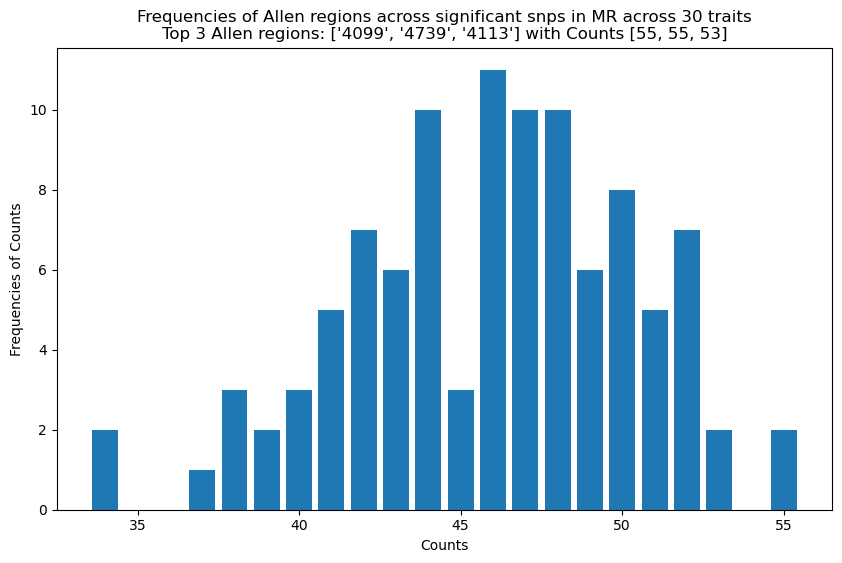

In [33]:
from collections import Counter

# Step 1: Count frequency of each element
element_counts = Counter(significant_pairs['region'])

# Step 2: Count the frequency of these frequencies
count_frequencies = Counter(element_counts.values())

# Step 3: Get the top 3 elements and their counts
top_3_elements = element_counts.most_common(3)
top_elements = [item[0] for item in top_3_elements]
top_counts = [item[1] for item in top_3_elements]

# Prepare data for plotting the frequency of counts
counts, frequencies = zip(*count_frequencies.items())

# Plot the histogram of frequency of counts
plt.figure(figsize=(10, 6))
plt.bar(counts, frequencies)
plt.xlabel('Counts')
plt.ylabel('Frequencies of Counts')
plt.yticks(range(0, max(frequencies) + 1, 2))

# Add title with unique elements, top 3 elements, and their counts
plt.title(f'Frequencies of Allen regions across significant snps in MR across {len(dataset_list)} traits\n'
          f'Top 3 Allen regions: {top_elements} with Counts {top_counts}')
plt.show()

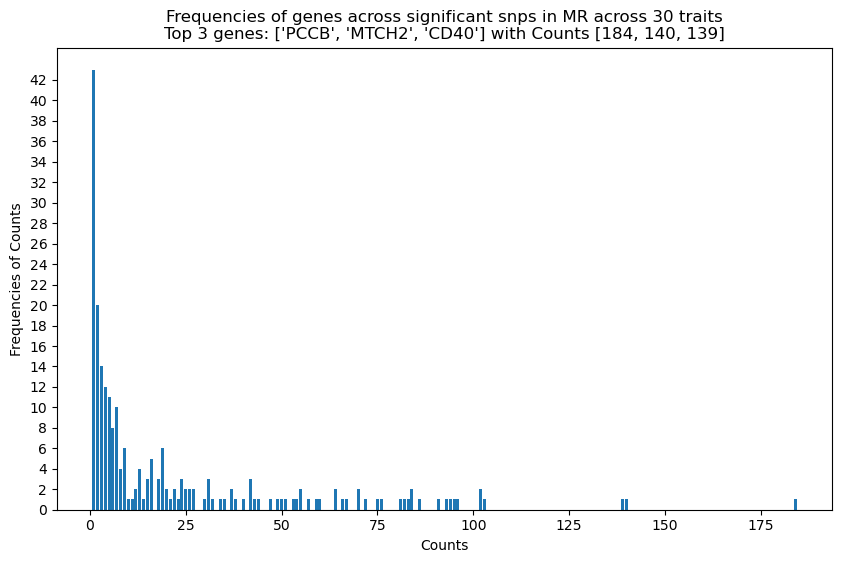

In [34]:
from collections import Counter

# Step 1: Count frequency of each element
element_counts = Counter(significant_pairs['gene_name'])

# Step 2: Count the frequency of these frequencies
count_frequencies = Counter(element_counts.values())

# Step 3: Get the top 3 elements and their counts
top_3_elements = element_counts.most_common(3)
top_elements = [item[0] for item in top_3_elements]
top_counts = [item[1] for item in top_3_elements]

# Prepare data for plotting the frequency of counts
counts, frequencies = zip(*count_frequencies.items())

# Plot the histogram of frequency of counts
plt.figure(figsize=(10, 6))
plt.bar(counts, frequencies)
plt.xlabel('Counts')
plt.ylabel('Frequencies of Counts')
plt.yticks(range(0, max(frequencies) + 1, 2))

# Add title with unique elements, top 3 elements, and their counts
plt.title(f'Frequencies of genes across significant snps in MR across {len(dataset_list)} traits\n'
          f'Top 3 genes: {top_elements} with Counts {top_counts}')
plt.show()

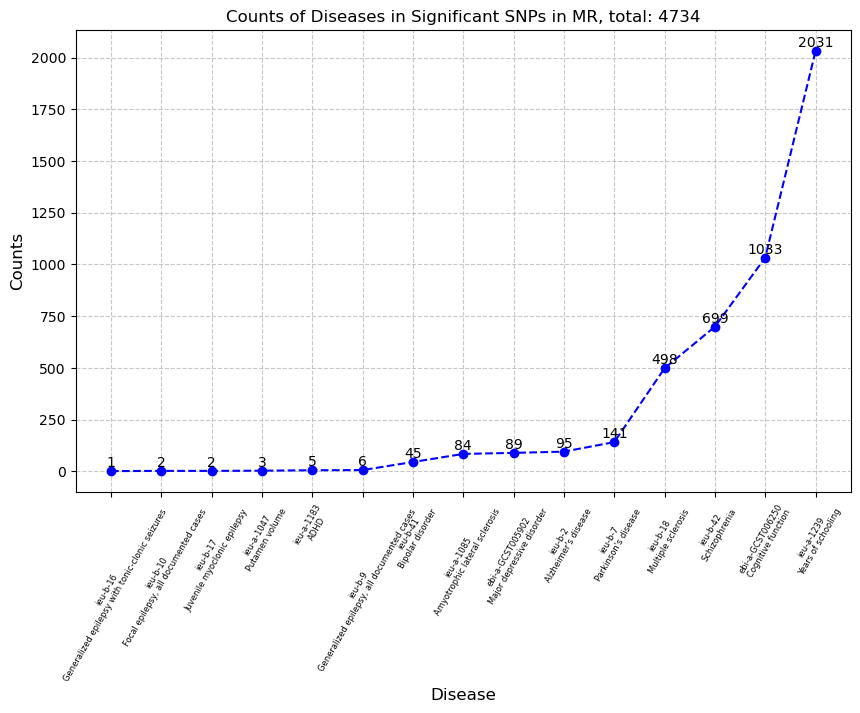

In [43]:
# Step 1: Count frequency of each element
element_counts = Counter(significant_pairs['dataset'])

# Sort elements by count in ascending order
sorted_elements = sorted(element_counts.items(), key=lambda x: x[1])
elements, counts = zip(*sorted_elements)  # Separate elements and counts for plotting

trait_names = [trait_name_list[dataset_list.index(d)] for d in elements]
combined_labels = [f"{dataset}\n{trait}" for dataset, trait in zip(elements, trait_names)]

# Plotting the line graph with customizations
plt.figure(figsize=(10, 6))
plt.plot(elements, counts, marker='o', linestyle='--', color='blue')  # Dashed line, blue color

# Add data labels above each point
for i, count in enumerate(counts):
    plt.text(elements[i], count + 5, str(count), ha='center', va='bottom', fontsize=10, color='black')

# Customizations
plt.xlabel('Disease', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(ticks=elements, labels=combined_labels, rotation=60, fontsize=6)  # Use combined labels for x-axis
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines

# Add title with increased font size and include top 3 elements and their counts
plt.title(f'Counts of Diseases in Significant SNPs in MR, total: {significant_pairs.shape[0]}', fontsize=12)

plt.show()

# coloc results analysis

In [2]:
# dataset_list = ['ieu-a-1043', 'ieu-a-1044', 'ieu-a-1045', 'ieu-a-1041', 'ieu-a-1042', 
#                 'ieu-a-1046', 'ieu-a-1047', 'ieu-a-1048', 'ieu-a-1183', 'ieu-b-2', 
#                 'ieu-a-1085', 'ieu-a-1185', 'ieu-b-41', 'ieu-b-13', 'ieu-b-8', 
#                 'ieu-b-10', 'ieu-b-14', 'ieu-b-11', 'ieu-b-15', 'ieu-b-16', 
#                 'ieu-b-9', 'ieu-b-12', 'ieu-b-17', 'ieu-b-43', 'ebi-a-GCST005902', 
#                 'ieu-b-18', 'ieu-b-7', 'ieu-b-42', 'ebi-a-GCST006250', 'ieu-a-1239']

# # find all allen regions
# save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_8_or_less/Prediction/300_500_by_subject/'
# filename = 'GTEX-1192X_300_500_trainable_LMfromGTEx.csv'
# df = pd.read_csv(save_dir+filename, index_col=0)
# keys = df.columns

# coloc_result_by_region = {}
# for allen_region in keys:
#     save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/coloc_results/"
#     filename = str(allen_region) + "_coloc_results_method1_local.csv"
#     coloc_result_by_region[allen_region] = pd.read_csv(save_dir+filename)
    
# coloc_summarized_result = pd.concat(coloc_result_by_region.values(), axis=0, ignore_index=True)
# # save the results
# save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/coloc_summarized_results/"
# filename = f"coloc_summarized_results_method1_local_across_{len(dataset_list)}_traits.csv"
# coloc_summarized_result.to_csv(save_dir+filename, header=True, index=False)

In [3]:
# find all allen regions
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_8_or_less/Prediction/300_500_by_subject/'
filename = 'GTEX-1192X_300_500_trainable_LMfromGTEx.csv'
df = pd.read_csv(save_dir+filename, index_col=0)
keys = df.columns

# which dataset here
dataset_list = ['ieu-a-1043', 'ieu-a-1044', 'ieu-a-1045', 'ieu-a-1041', 'ieu-a-1042', 
                'ieu-a-1046', 'ieu-a-1047', 'ieu-a-1048', 'ieu-a-1183', 'ieu-b-2', 
                'ieu-a-1085', 'ieu-a-1185', 'ieu-b-41', 'ieu-b-13', 'ieu-b-8', 
                'ieu-b-10', 'ieu-b-14', 'ieu-b-11', 'ieu-b-15', 'ieu-b-16', 
                'ieu-b-9', 'ieu-b-12', 'ieu-b-17', 'ieu-b-43', 'ebi-a-GCST005902', 
                'ieu-b-18', 'ieu-b-7', 'ieu-b-42', 'ebi-a-GCST006250', 'ieu-a-1239']
trait_name_list = ["Amygdala volume", "Caudate volume", "Hippocampus volume", "Intracranial volume", "Nucleus accumbens volume", 
                   "Pallidum volume", "Putamen volume", "Thalamus volume", "ADHD", "Alzheimer's disease", 
                   "Amyotrophic lateral sclerosis", "Autism spectrum disorder", "Bipolar disorder", "Childhood absence epilepsy", "Epilepsy, all documented cases", 
                   "Focal epilepsy, all documented cases", "Focal epilepsy, documented hippocampal sclerosis", "Focal epilepsy, documented lesion negative", "Focal epilepsy, documented lesion other than hippocampal sclerosis", "Generalized epilepsy with tonic-clonic seizures", 
                   "Generalized epilepsy, all documented cases", "Juvenile absence epilepsy", "Juvenile myoclonic epilepsy", "Frontotemporal dementia - TDP subtype", "Major depressive disorder", 
                   "Multiple sclerosis", "Parkinson's disease", "Schizophrenia", "Cognitive function", "Years of schooling"]
trait_name_abv_list = ["Amygdala volume", "Caudate volume", "Hippocampus volume", "Intracranial volume", "Nucleus accumbens volume", 
                       "Pallidum volume", "Putamen volume", "Thalamus volume", "ADHD", "AD", 
                       "ALS", "ASD", "BD", "CAE", "EPI", 
                       "Focal EPI 1", "Focal EPI 2", "Focal EPI 3", "Focal EPI 4", "Generalized EPI 1", 
                       "Generalized EPI 2", "JAE", "JME", "FTD", "MDD", 
                       "MS", "PD", "Schizophrenia", "Cognitive function", "Years of schooling"]

save_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/coloc+MR/coloc_summarized_results/"
filename = f"coloc_summarized_results_method1_local_across_{len(dataset_list)}_traits.csv"
coloc_summarized_result = pd.read_csv(save_dir+filename)
coloc_summarized_result_sig = coloc_summarized_result[coloc_summarized_result['pass_coloc']==True]

In [4]:
# find the mapping actual allen region names
file_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/allen_table/"
filename = '2011_Allen_Supplementary_Table2.xls'
allen_supp2 = pd.read_excel(file_dir+filename, sheet_name=1, engine='xlrd')
# find the sub-matrix with only our keys
keys_list = [int(k) for k in keys.tolist()]
allen_supp2_sub = allen_supp2[allen_supp2['ID'].isin(keys_list)]
# find the mapped region names for allen regions
mapped_names = []
for allen_id in keys:
    allen_id = int(allen_id)
    row_idx = allen_supp2_sub['ID'].tolist().index(allen_id)
    for col_idx in range(8,15):
        element = allen_supp2_sub.iloc[row_idx,col_idx]
        if pd.isna(element)==False:
            mapped_names.append(element)
# remove "Left" from the mapped names
mapped_names = [name.replace(", Left", "") for name in mapped_names]

### Number of snps by traits

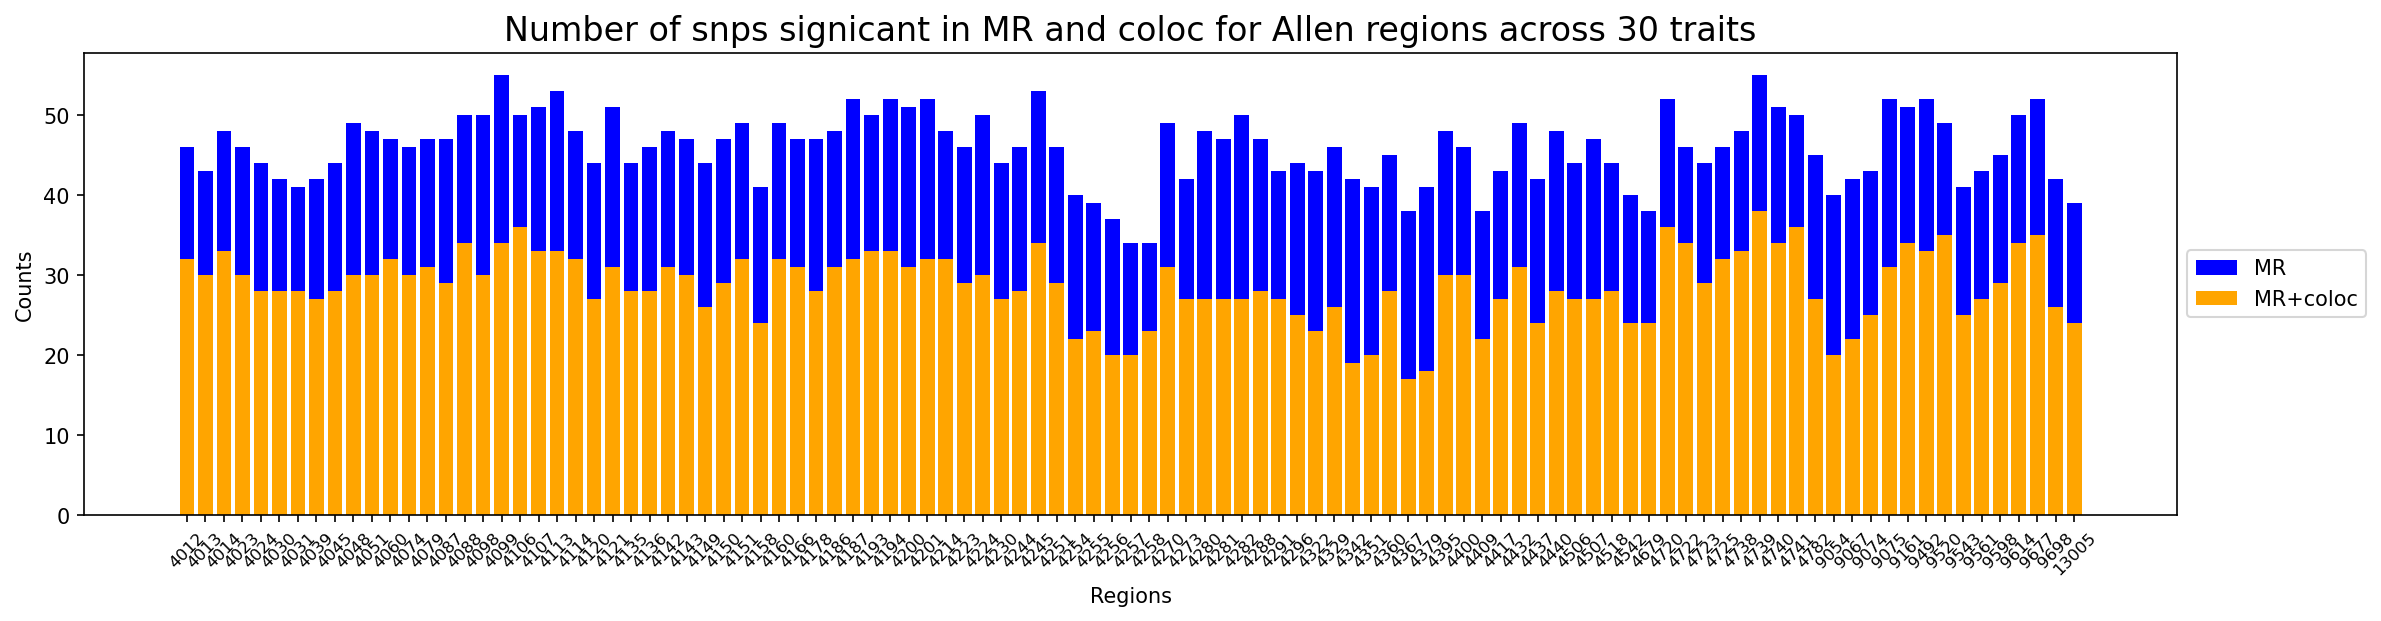

In [5]:
# Step 1: Count frequency of each element
element_counts = Counter(coloc_summarized_result['region'])
element_counts_sig = Counter(coloc_summarized_result_sig['region'])

# Extract keys and values for plotting
labels = [str(x) for x in element_counts.keys()]  # x-axis labels
frequencies = list(element_counts.values())  # y-axis values
frequencies_sig = list(element_counts_sig.values())

plt.figure(figsize=(18, 4), dpi=150)

# Create the bar plot
plt.bar(labels, frequencies, color='blue', label='MR')
plt.bar(labels, frequencies_sig, color='orange', label='MR+coloc')

# Add labels and title
plt.xlabel('Regions')
plt.ylabel('Counts')
plt.xticks(rotation=45, fontsize=8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Add title with unique elements, top 3 elements, and their counts
plt.title(f'Number of snps signicant in MR and coloc for Allen regions across {len(dataset_list)} traits', fontsize=16)
plt.show()

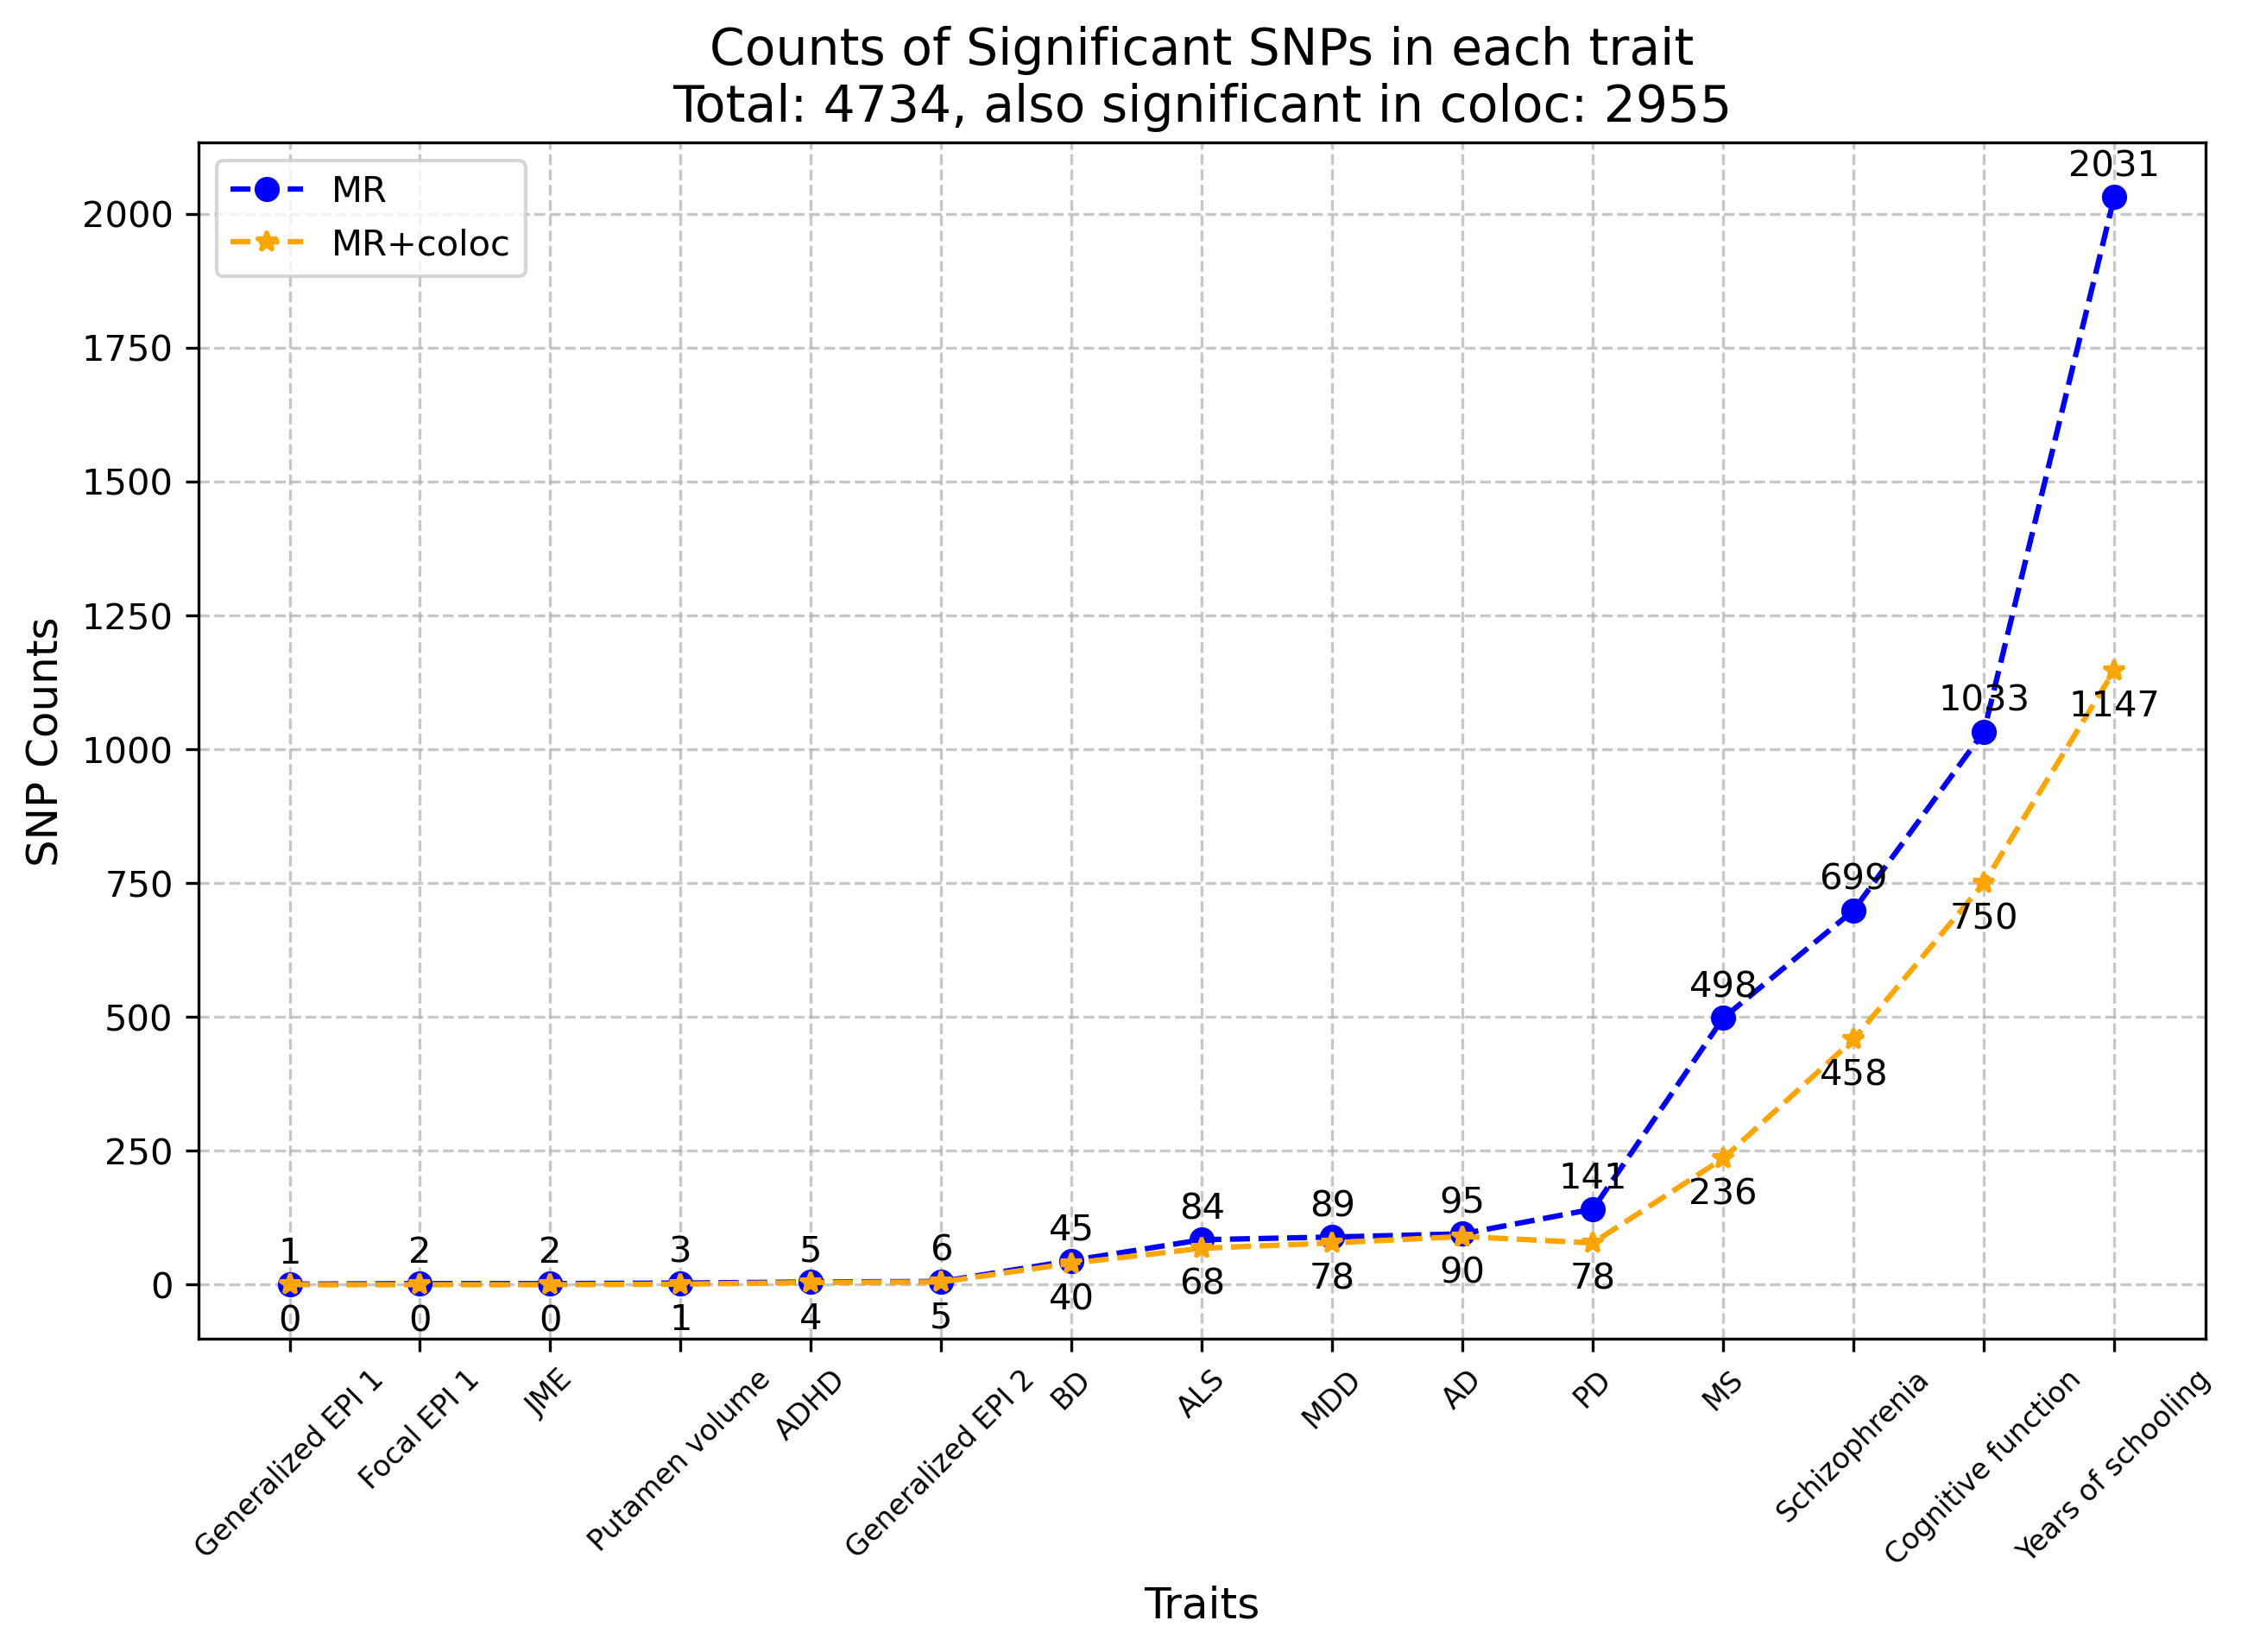

In [15]:
# Step 1: Count frequency of each element
element_counts = Counter(coloc_summarized_result['dataset'])
element_counts_sig = Counter(coloc_summarized_result_sig['dataset'])

# Sort elements by count in ascending order
sorted_elements = sorted(element_counts.items(), key=lambda x: x[1])
elements, counts = zip(*sorted_elements)  # Separate elements and counts for plotting
counts_sig = [element_counts_sig[e] for e in elements]

trait_abv_names = [trait_name_abv_list[dataset_list.index(d)] for d in elements]

# Plotting the line graph with customizations
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(elements, counts, marker='o', linestyle='--', color='blue', label="MR")  # Dashed line, blue color
plt.plot(elements, counts_sig, marker='*', linestyle='--', color='orange', label="MR+coloc")  # Dashed line, blue color
    
# Customizations
plt.xlabel('Traits', fontsize=12)
plt.ylabel('SNP Counts', fontsize=12)
plt.xticks(ticks=elements, labels=trait_abv_names, rotation=45, fontsize=8)  # Use combined labels for x-axis
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines
plt.legend(loc='upper left')

# Add data labels above each point
for i, count in enumerate(counts):
    plt.text(elements[i], count + 25, str(count), ha='center', va='bottom', fontsize=10, color='black')
for i, count in enumerate(counts_sig):
    plt.text(elements[i], count - 100, str(count), ha='center', va='bottom', fontsize=10, color='black')

# Add title with increased font size and include top 3 elements and their counts
plt.title(f'Counts of Significant SNPs in each trait\n' + 
          f'Total: {coloc_summarized_result.shape[0]}, ' + 
          f'also significant in coloc: {coloc_summarized_result_sig.shape[0]}', fontsize=14)

plt.show()

In [16]:
len(set(coloc_summarized_result_sig['gene_id']))

150

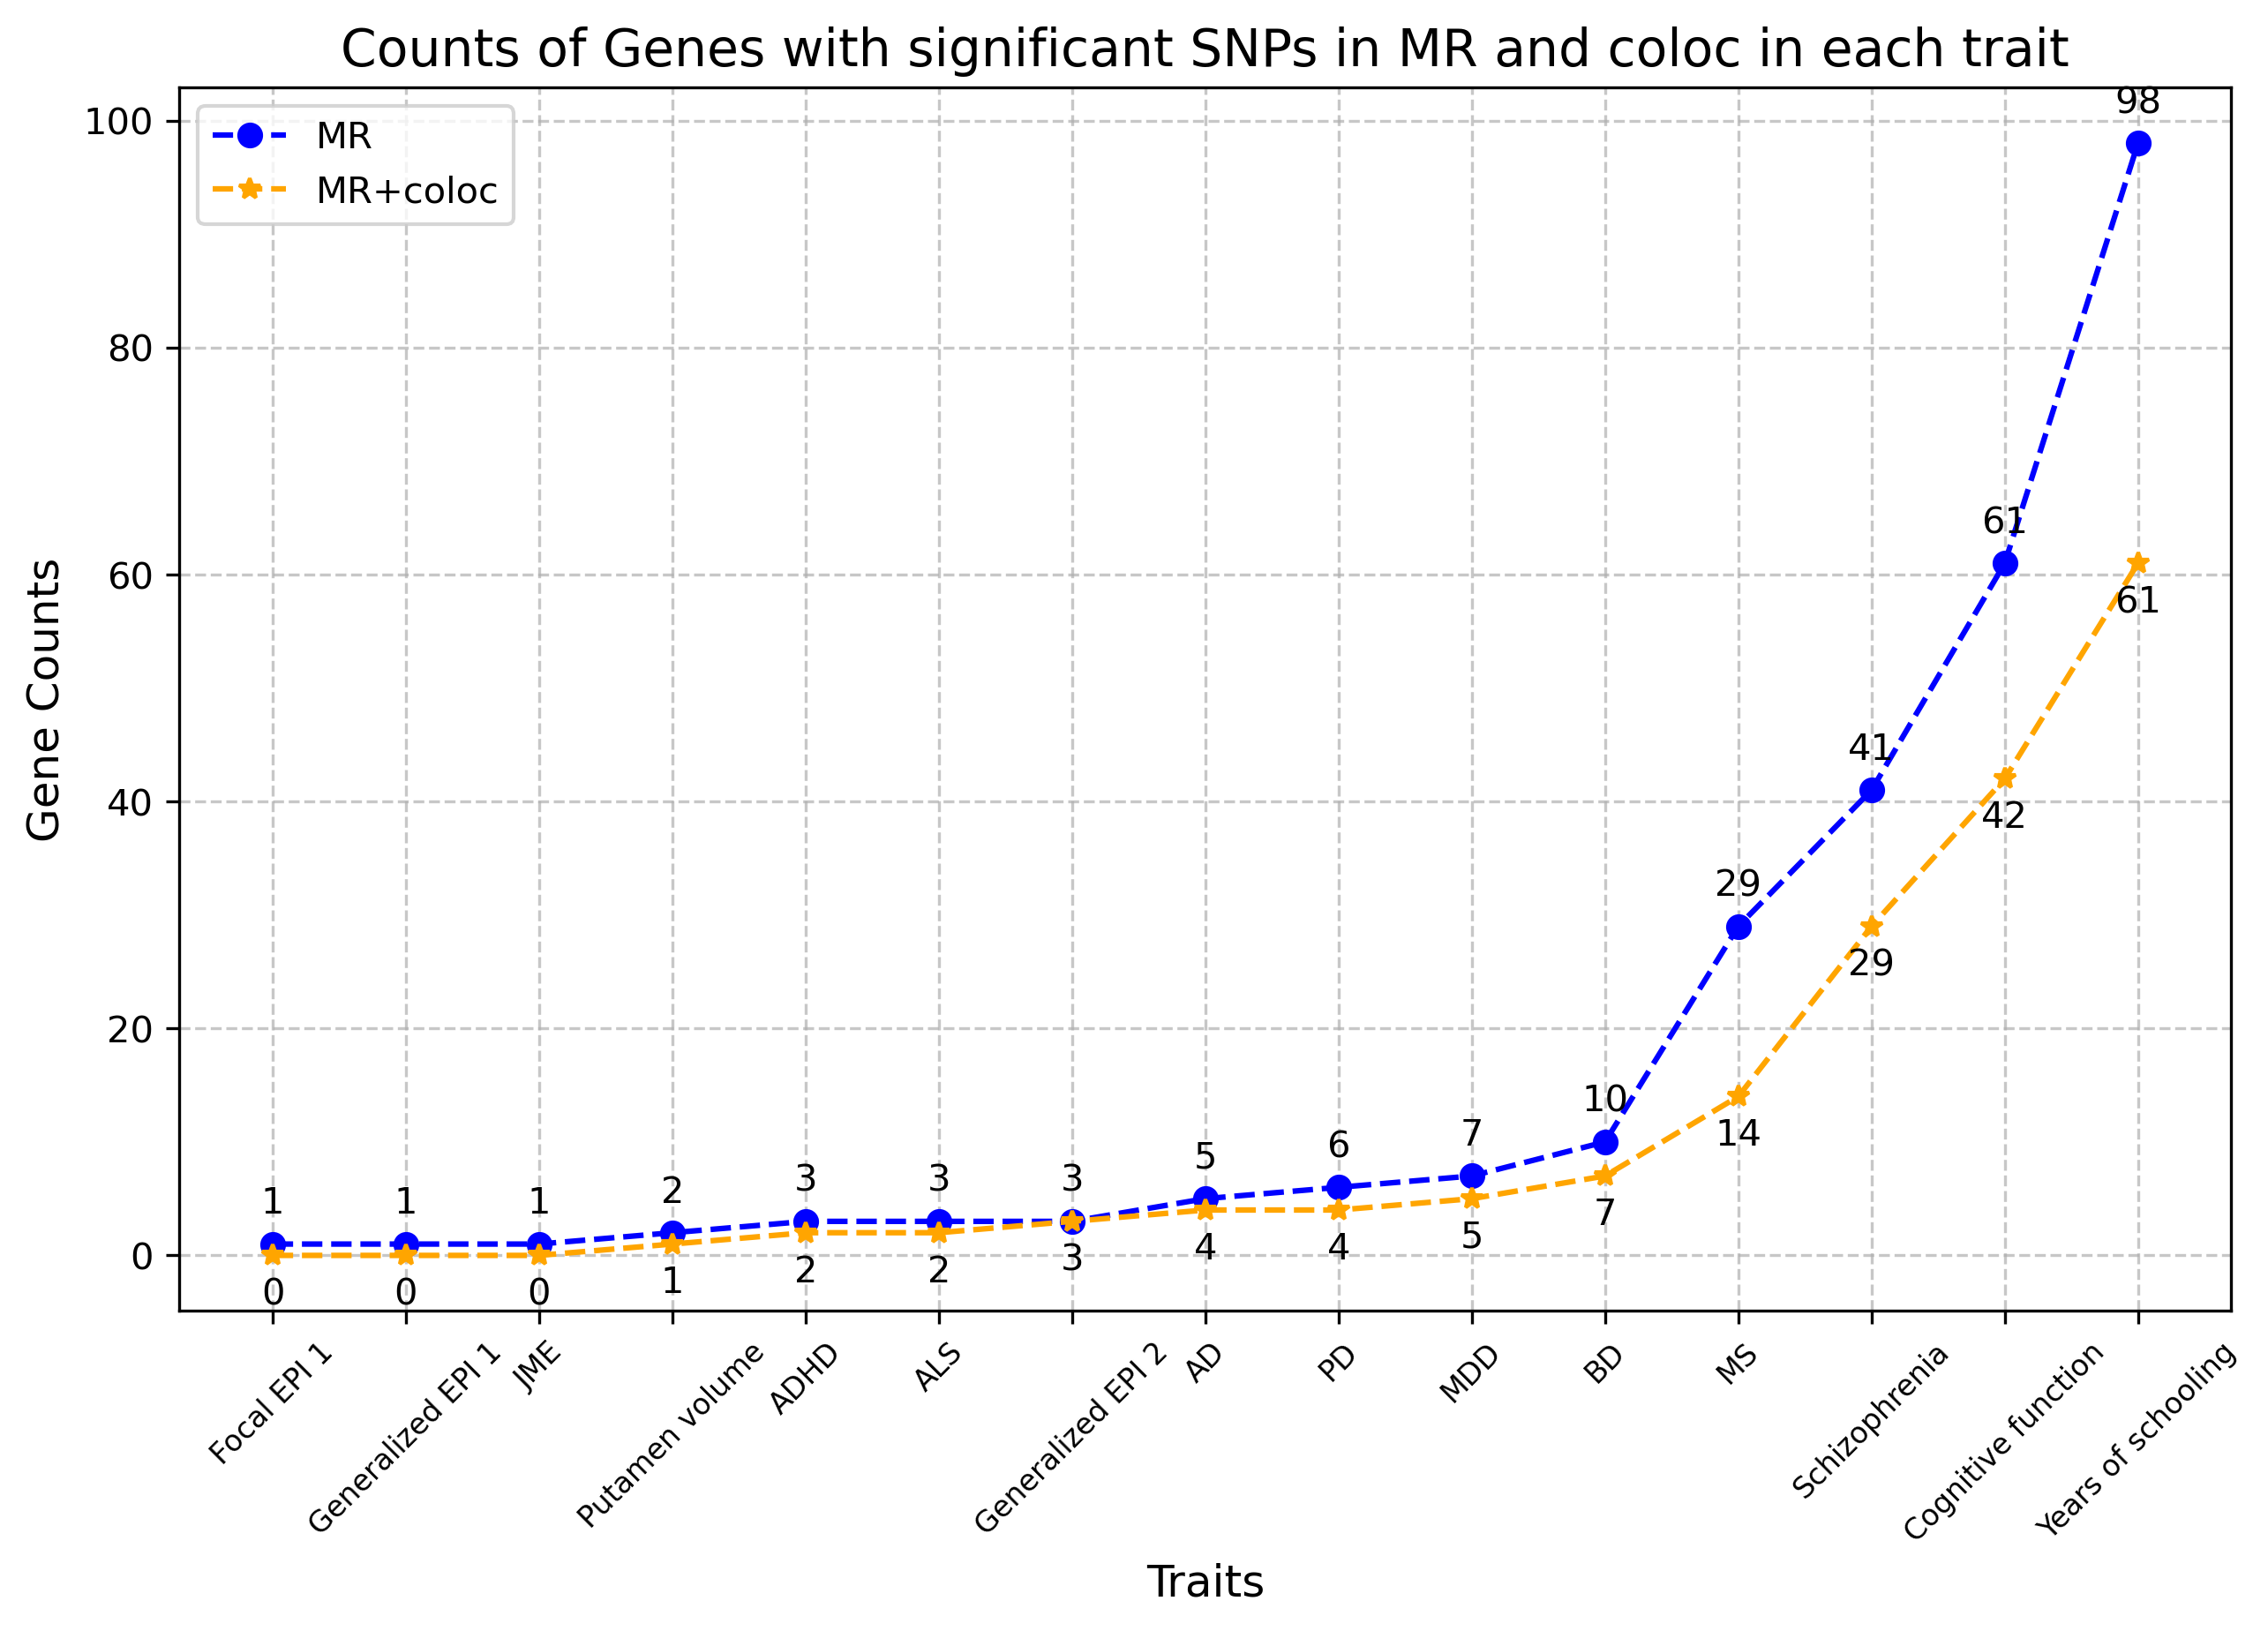

In [21]:
counts, counts_sig = {}, {}
for dataset in dataset_list:
    counts[dataset] = len(set(coloc_summarized_result[coloc_summarized_result['dataset']==dataset]['gene_name']))
    counts_sig[dataset] = len(set(coloc_summarized_result_sig[coloc_summarized_result_sig['dataset']==dataset]['gene_name']))
    
# Sort counts and counts_sig dictionaries by value (ascending order)
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1]))

# Extract sorted dataset names and values
datasets = list(sorted_counts.keys())  # x-axis labels
filtered_dataset = [d for d in datasets if (counts[d]+counts_sig[d])>0]
# only plot if the trait has at least one snp
traits_abv_names = [trait_name_abv_list[dataset_list.index(d)] for d in filtered_dataset]
frequencies = [counts[d] for d in filtered_dataset]
frequencies_sig = [counts_sig[d] for d in filtered_dataset]

# Plotting the line graph with customizations
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(len(traits_abv_names)), frequencies, marker='o', linestyle='--', color='blue', label="MR")  # Dashed line, blue color
plt.plot(range(len(traits_abv_names)), frequencies_sig, marker='*', linestyle='--', color='orange', label="MR+coloc")  # Dashed line, blue color

# Customizations
plt.xlabel('Traits', fontsize=12)
plt.ylabel('Gene Counts', fontsize=12)
plt.xticks(ticks=range(len(traits_abv_names)), labels=traits_abv_names, rotation=45, fontsize=8)  # Use combined labels for x-axis
plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines
plt.legend(loc='upper left')

for i in range(len(trait_abv_names)):
    plt.text(i, frequencies[i] + 2, str(frequencies[i]), ha='center', va='bottom', fontsize=10, color='black')
    plt.text(i, frequencies_sig[i] - 5, str(frequencies_sig[i]), ha='center', va='bottom', fontsize=10, color='black')

# Add title with increased font size and include top 3 elements and their counts
plt.title(f'Counts of Genes with significant SNPs in MR and coloc in each trait', fontsize=14)

plt.show()

In [22]:
counts_sig

{'ieu-a-1043': 0,
 'ieu-a-1044': 0,
 'ieu-a-1045': 0,
 'ieu-a-1041': 0,
 'ieu-a-1042': 0,
 'ieu-a-1046': 0,
 'ieu-a-1047': 1,
 'ieu-a-1048': 0,
 'ieu-a-1183': 2,
 'ieu-b-2': 4,
 'ieu-a-1085': 2,
 'ieu-a-1185': 0,
 'ieu-b-41': 7,
 'ieu-b-13': 0,
 'ieu-b-8': 0,
 'ieu-b-10': 0,
 'ieu-b-14': 0,
 'ieu-b-11': 0,
 'ieu-b-15': 0,
 'ieu-b-16': 0,
 'ieu-b-9': 3,
 'ieu-b-12': 0,
 'ieu-b-17': 0,
 'ieu-b-43': 0,
 'ebi-a-GCST005902': 5,
 'ieu-b-18': 14,
 'ieu-b-7': 4,
 'ieu-b-42': 29,
 'ebi-a-GCST006250': 42,
 'ieu-a-1239': 61}

In [18]:
counts_sig

{'ieu-a-1043': 0,
 'ieu-a-1044': 0,
 'ieu-a-1045': 0,
 'ieu-a-1041': 0,
 'ieu-a-1042': 0,
 'ieu-a-1046': 0,
 'ieu-a-1047': 1,
 'ieu-a-1048': 0,
 'ieu-a-1183': 2,
 'ieu-b-2': 4,
 'ieu-a-1085': 2,
 'ieu-a-1185': 0,
 'ieu-b-41': 7,
 'ieu-b-13': 0,
 'ieu-b-8': 0,
 'ieu-b-10': 0,
 'ieu-b-14': 0,
 'ieu-b-11': 0,
 'ieu-b-15': 0,
 'ieu-b-16': 0,
 'ieu-b-9': 3,
 'ieu-b-12': 0,
 'ieu-b-17': 0,
 'ieu-b-43': 0,
 'ebi-a-GCST005902': 5,
 'ieu-b-18': 14,
 'ieu-b-7': 4,
 'ieu-b-42': 29,
 'ebi-a-GCST006250': 42,
 'ieu-a-1239': 61}

In [9]:
# counts, counts_sig = {}, {}
# for dataset in dataset_list:
#     counts[dataset] = coloc_summarized_result[coloc_summarized_result['dataset']==dataset].shape[0]
#     counts_sig[dataset] = coloc_summarized_result_sig[coloc_summarized_result_sig['dataset']==dataset].shape[0]
    
# # Sort counts and counts_sig dictionaries by value (ascending order)
# sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1]))
# sorted_counts_sig = dict(sorted(counts_sig.items(), key=lambda item: item[1]))

# # Extract sorted dataset names and values
# datasets = list(sorted_counts.keys())  # x-axis labels
# traits = [trait_name_list[dataset_list.index(d)] for d in datasets]
# combined_labels = [f"{dataset}\n{trait}" for dataset, trait in zip(datasets, traits)]
# frequencies = list(sorted_counts.values())  # y-axis values for counts
# frequencies_sig = [sorted_counts_sig.get(dataset, 0) for dataset in datasets]  # y-axis values for counts_sig

# # Set up the figure
# plt.figure(figsize=(12, 6))

# # Plot the bars
# plt.bar(combined_labels, frequencies, color='blue', label='MR')
# plt.bar(combined_labels, frequencies_sig, color='orange', label='MR+coloc')

# # Add labels, title, and legend
# plt.xlabel('Datasets')
# plt.ylabel('Number of Elements')
# plt.legend(loc='upper left')
# # plt.yscale('log')

# # Rotate x-axis labels for readability
# plt.xticks(rotation=45, fontsize=6)
# # title
# plt.title(f'Counts of snps significant in MR and coloc, mr total: {coloc_summarized_result.shape[0]}, mr+coloc total: {coloc_summarized_result_sig.shape[0]}', fontsize=12)

# # Display the plot
# plt.show()

In [10]:
# counts, counts_sig = {}, {}
# for dataset in dataset_list:
#     counts[dataset] = len(set(coloc_summarized_result[coloc_summarized_result['dataset']==dataset]['gene_name']))
#     counts_sig[dataset] = len(set(coloc_summarized_result_sig[coloc_summarized_result_sig['dataset']==dataset]['gene_name']))
    
# # Sort counts and counts_sig dictionaries by value (ascending order)
# sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1]))
# sorted_counts_sig = dict(sorted(counts_sig.items(), key=lambda item: item[1]))

# # Extract sorted dataset names and values
# datasets = list(sorted_counts.keys())  # x-axis labels
# traits = [trait_name_list[dataset_list.index(d)] for d in datasets]
# combined_labels = [f"{dataset}\n{trait}" for dataset, trait in zip(datasets, traits)]
# frequencies = list(sorted_counts.values())  # y-axis values for counts
# frequencies_sig = [sorted_counts_sig.get(dataset, 0) for dataset in datasets]  # y-axis values for counts_sig

# # Set up the figure
# plt.figure(figsize=(12, 6))

# # Plot the bars
# plt.bar(combined_labels, frequencies, color='blue', label='MR')
# plt.bar(combined_labels, frequencies_sig, color='orange', label='MR+coloc')

# # Add labels, title, and legend
# plt.xlabel('Datasets')
# plt.ylabel('Number of Elements')
# plt.legend(loc='upper left')
# # plt.yscale('log')

# # Rotate x-axis labels for readability
# plt.xticks(rotation=45, fontsize=6)
# # title
# plt.title(f'Counts of genes significant in MR and coloc', fontsize=12)

# # Display the plot
# plt.show()

### Case study for one trait

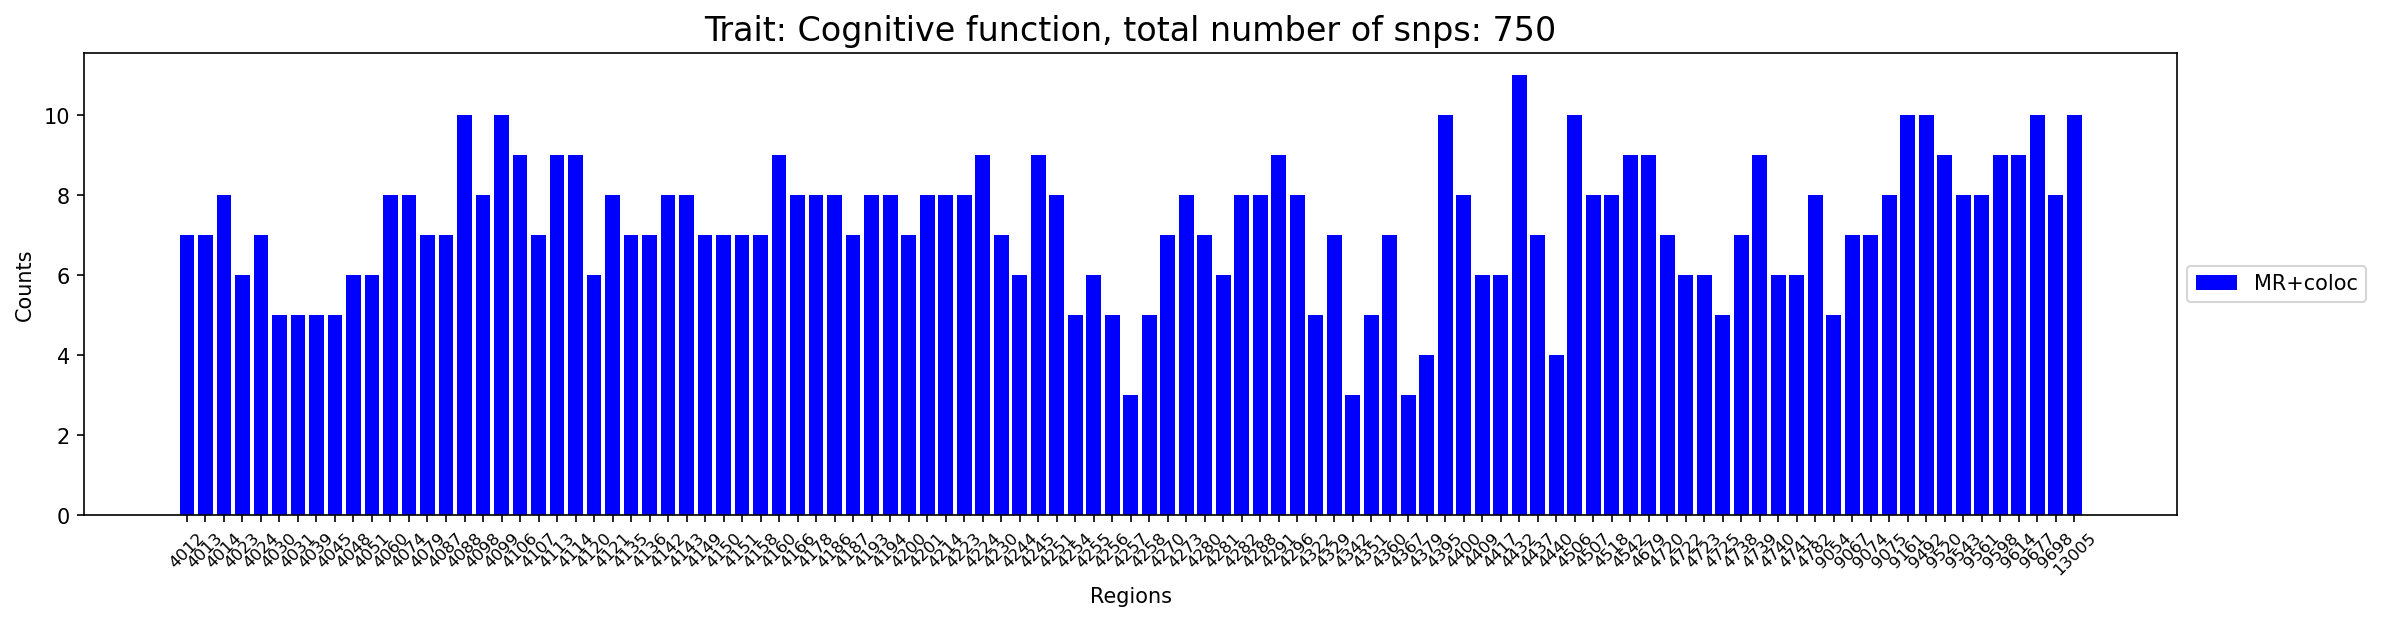

In [9]:
picked_trait = trait_name_list[28]
coloc_sig_sub = coloc_summarized_result_sig[coloc_summarized_result_sig['trait']==picked_trait]

# Count frequency of each element
element_counts = Counter(coloc_sig_sub['region'])

# Extract keys and values for plotting
labels = [str(x) for x in element_counts.keys()]  # x-axis labels
frequencies = list(element_counts.values())  # y-axis values

plt.figure(figsize=(18, 4), dpi=150)

# Create the bar plot
plt.bar(labels, frequencies, color='blue', label='MR+coloc')

# Add labels and title
plt.xlabel('Regions')
plt.ylabel('Counts')
plt.xticks(rotation=45, fontsize=8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Add title with unique elements, top 3 elements, and their counts
plt.title(f'Trait: {picked_trait}, total number of snps: {coloc_sig_sub.shape[0]}', fontsize=16)
plt.show()

### similarity between regions

In [10]:
# find genes for each trait
counts_sig = {}
for dataset in dataset_list:
    counts_sig[dataset] = sorted(list(set(coloc_summarized_result_sig[coloc_summarized_result_sig['dataset']==dataset]['gene_name'])))
# build the matrix 
trait_index, gene_index = [], []
for key in counts_sig.keys():
    trait_name = trait_name_list[dataset_list.index(key)]
    gene_list = counts_sig[key]
    for gene in gene_list:
        trait_index.append(trait_name)
        gene_index.append(gene)
# iterate over each significant snps in MR+coloc
count_df = pd.DataFrame(np.zeros((len(trait_index), len(keys)), dtype=int), 
                        index=pd.MultiIndex.from_arrays([trait_index, gene_index], names=['trait', 'gene']), columns=keys.tolist())
for i in range(coloc_summarized_result_sig.shape[0]):
    gene = coloc_summarized_result_sig['gene_name'].tolist()[i]
    trait = coloc_summarized_result_sig['trait'].tolist()[i]
    region = str(coloc_summarized_result_sig['region'].tolist()[i])
    count_df.loc[(trait, gene), region] = 1

In [11]:
count_df

4012  4013  4014  4023  4024  4030  4031  4039  \
trait               gene                                                      
Putamen volume      MYLK2       0     0     0     0     0     0     0     0   
ADHD                CISD2       0     0     0     0     0     0     0     0   
                    GMPPB       0     0     0     0     0     0     0     0   
Alzheimer's disease C1QTNF4     0     0     0     0     0     0     0     0   
                    CR1         0     0     0     0     0     0     0     0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
Years of schooling  UBOX5       0     0     1     0     1     0     0     0   
                    USP33       0     0     0     0     0     0     0     0   
                    VWA3B       0     0     0     0     0     0     0     0   
                    WDR27       0     0     0     0     0     0     0     0   
                    XRCC3       0     0     0     0     0     0     0     0   

                             4045  4048  ...  9161  9492  9520  9543  9561  \
trait               gene                 ...                                 
Putamen volume      MYLK2       0     0  ...     0     0     0     0     0   
ADHD                CISD2       0     0  ...     0     0     0     0     0   
                    GMPPB       0     0  ...     0     0     0     0     0   
Alzheimer's disease C1QTNF4     0     0  ...     0     0     0     0     0   
                    CR1         0     0  ...     0     0     1     0     0   
...                           ...   ...  ...   ...   ...   ...   ...   ...   
Years of schooling  UBOX5       0     0  ...     0     0     0     0     0   
                    USP33       0     0  ...     0     0     0     0     0   
                    VWA3B       0     0  ...     1     1     1     1     1   
                    WDR27       0     0  ...     0     0     0     0     0   
                    XRCC3       0     0  ...     0     0     0     0     0   

                             9598  9614  9677  9698  13005  
trait               gene                                    
Putamen volume      MYLK2       0     0     0     0      0  
ADHD                CISD2       0     0     0     0      0  
                    GMPPB       0     0     0     0      0  
Alzheimer's disease C1QTNF4     0     0     0     0      0  
                    CR1         0     1     0     0      0  
...                           ...   ...   ...   ...    ...  
Years of schooling  UBOX5       0     0     0     0      0  
                    USP33       0     0     0     0      0  
                    VWA3B       1     1     1     1      0  
                    WDR27       0     0     0     0      0  
                    XRCC3       0     0     0     0      0  

[174 rows x 103 columns]

In [12]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from matplotlib.colors import Normalize
# import matplotlib.cm as cm

# # Assuming `trait_name_abv_list`, `keys`, `trait_name_list`, and `coloc_summarized_result_sig` are already defined

# # Create DataFrame for SNP counts
# count_df = pd.DataFrame(np.zeros((len(trait_name_abv_list), len(keys)), dtype=int), 
#                         index=trait_name_abv_list, columns=keys.tolist())
# region_labels = [f"{mapped_names[i]} ({keys[i]})" for i in range(len(keys))]

# my_dict = {'Cerebral Cortex': keys.tolist()[:55], 
#            'Cerebral Nuclei': keys.tolist()[55:68], 
#            'Thalamus': ['4395', '4400', '4409', '4417', '4432', '4437', '4440', '4506', '4507'], 
#            'Subthalamus': ['4518'], 
#            'Hypothalamus': ['4542', '4679', '13005'], 
#            'Cerebellum': ['4720', '4722', '4723', '4725', '4738', '4739', '4740', '4741', '4782'], 
#            'Midbrain Tegmentum': ['9054', '9067', '9074', '9075'], 
#            'Pons': ['9161', '9492'], 
#            'Level 3 region Myelencephalon': ['9520', '9543', '9561', '9598', '9614', '9677', '9698']}
# colors = ['#FF69B4', '#FFD700', '#32CD32', '#8A2BE2', '#FF4500', '#40E0D0', '#FF8C00', '#A52A2A', '#DAA520']

# # Count the number of SNPs
# for region in keys.tolist():
#     for trait_name_abv in trait_name_abv_list:
#         trait_full_name = trait_name_list[trait_name_abv_list.index(trait_name_abv)]
#         sub_mat = coloc_summarized_result_sig[(coloc_summarized_result_sig['trait'] == trait_full_name) &
#                                               (coloc_summarized_result_sig['region'] == pd.to_numeric(region))]
#         count_df.loc[trait_name_abv, region] = sub_mat.shape[0]
#         # count_df.loc[trait_name_abv, region] = len(set(sub_mat['gene_name']))

# # Filter rows with at least one SNP
# df_filtered = count_df[count_df.sum(axis=1) > 0]
# # transpose the matrix
# df_filtered = df_filtered.T

# # Define normalization
# norm = Normalize(vmin=0, vmax=df_filtered.to_numpy().max())

# # Set up the figure
# plt.figure(figsize=(4, 15), dpi=200)

# # Mask 0 values to make them appear white
# masked_data = np.ma.masked_where(df_filtered == 0, df_filtered)

# # Create the colormap and set masked values to white
# cmap = plt.colormaps['viridis'].copy()  # Use the new colormap syntax
# cmap.set_bad(color='white')  # Set masked values to white

# # Plot the heatmap
# plt.imshow(masked_data, cmap=cmap, aspect='auto')

# # Add a white grid
# ax = plt.gca()  # Get current axis
# ax.set_xticks(np.arange(-0.5, len(df_filtered.columns), 1), minor=True)
# ax.set_yticks(np.arange(-0.5, len(df_filtered.index), 1), minor=True)
# ax.grid(which="minor", color="white", linestyle='-', linewidth=0.15)  # White gridlines
# ax.tick_params(which="minor", size=0)  # Hide minor tick marks

# # Add the colorbar
# cbar = plt.colorbar(label='SNP Count', shrink=0.5)
# cbar.ax.tick_params(labelsize=8)  # Adjust color bar tick font size

# # Set the row and column labels
# plt.xticks(ticks=np.arange(len(df_filtered.columns)), labels=df_filtered.columns, rotation=90, fontsize=7)
# plt.yticks(ticks=np.arange(len(df_filtered.index)), labels=region_labels, fontsize=6)

# # Add titles and labels
# plt.title("Number of SNPs in each trait each Allen region", fontsize=10)
# plt.xlabel("Traits", fontsize=8)
# plt.ylabel("Allen regions", fontsize=8)

# # Show the plot
# plt.show()

# # coloc_summarized_result_sig[(coloc_summarized_result_sig['trait'] == "Years of schooling") & (coloc_summarized_result_sig['region'] == 4725)]


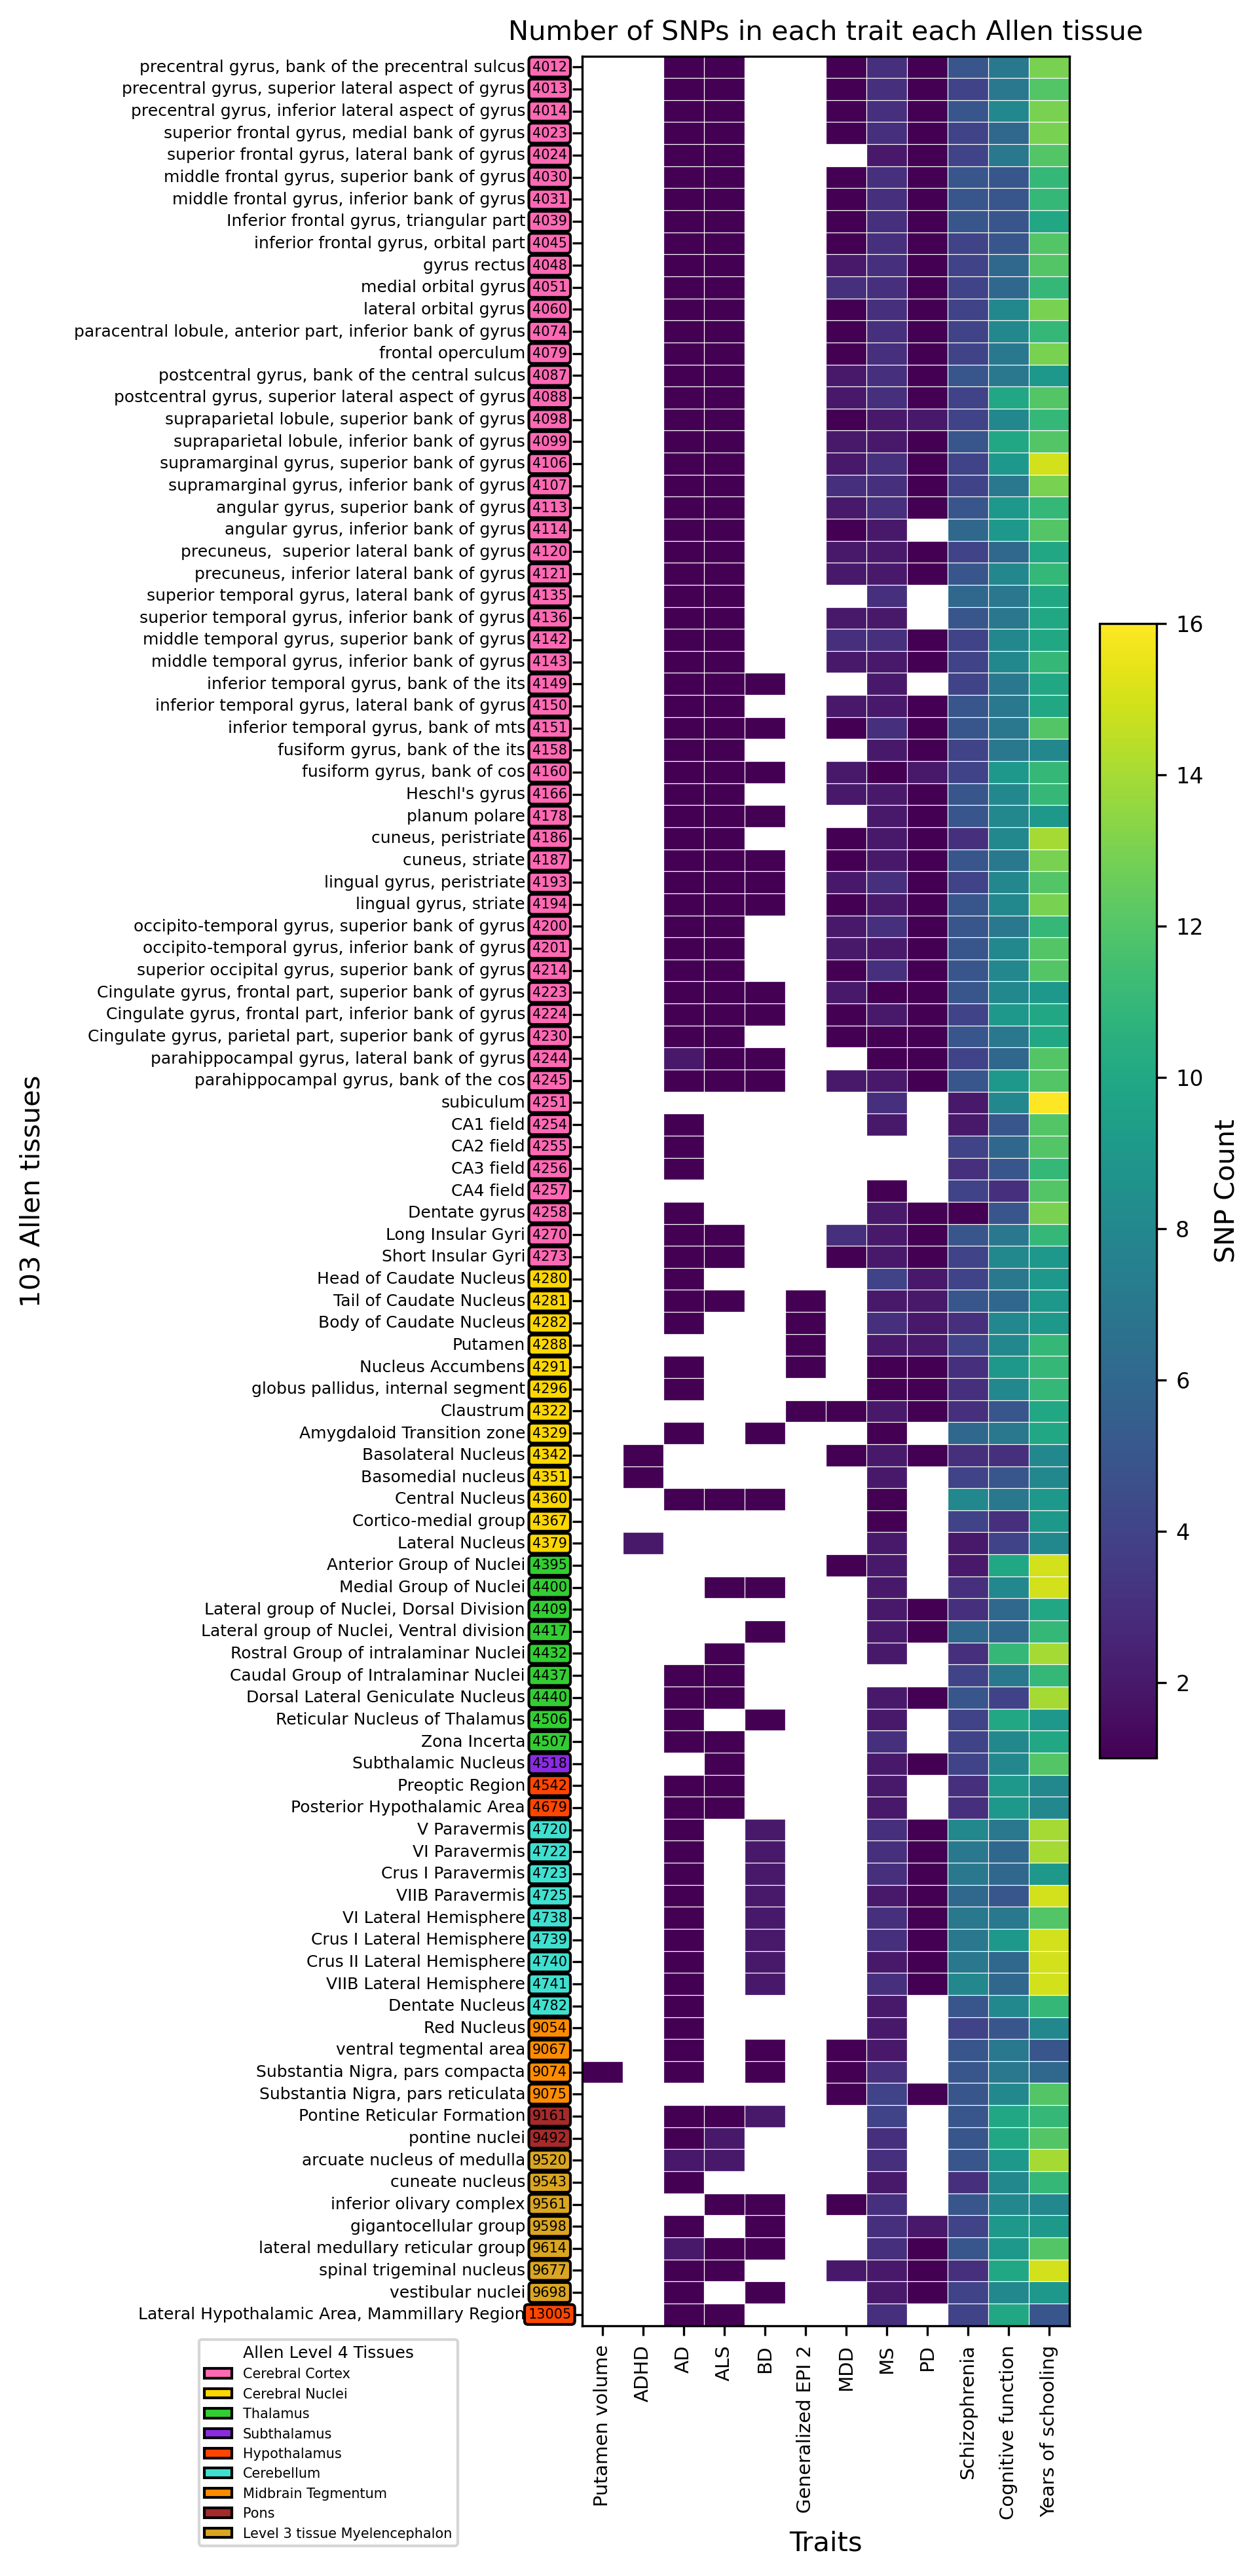

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.patches import Patch

# Assuming `trait_name_abv_list`, `keys`, `trait_name_list`, and `coloc_summarized_result_sig` are already defined

# Create DataFrame for SNP counts
count_df = pd.DataFrame(np.zeros((len(trait_name_abv_list), len(keys)), dtype=int), 
                        index=trait_name_abv_list, columns=keys.tolist())

# Use only keys as region labels
region_labels = [f"{keys[i]}" for i in range(len(keys))]

my_dict = {'Cerebral Cortex': keys.tolist()[:55], 
           'Cerebral Nuclei': keys.tolist()[55:68], 
           'Thalamus': ['4395', '4400', '4409', '4417', '4432', '4437', '4440', '4506', '4507'], 
           'Subthalamus': ['4518'], 
           'Hypothalamus': ['4542', '4679', '13005'], 
           'Cerebellum': ['4720', '4722', '4723', '4725', '4738', '4739', '4740', '4741', '4782'], 
           'Midbrain Tegmentum': ['9054', '9067', '9074', '9075'], 
           'Pons': ['9161', '9492'], 
           'Level 3 tissue Myelencephalon': ['9520', '9543', '9561', '9598', '9614', '9677', '9698']}
colors = ['#FF69B4', '#FFD700', '#32CD32', '#8A2BE2', '#FF4500', '#40E0D0', '#FF8C00', '#A52A2A', '#DAA520']

region_colors = {region: colors[i] for i, regions in enumerate(my_dict.values()) for region in regions}

# Count the number of SNPs
for region in keys.tolist():
    for trait_name_abv in trait_name_abv_list:
        trait_full_name = trait_name_list[trait_name_abv_list.index(trait_name_abv)]
        sub_mat = coloc_summarized_result_sig[(coloc_summarized_result_sig['trait'] == trait_full_name) &
                                              (coloc_summarized_result_sig['region'] == pd.to_numeric(region))]
        count_df.loc[trait_name_abv, region] = sub_mat.shape[0]

# Filter rows with at least one SNP
df_filtered = count_df[count_df.sum(axis=1) > 0]
# Transpose the matrix
df_filtered = df_filtered.T

# Define normalization
norm = Normalize(vmin=0, vmax=df_filtered.to_numpy().max())

# Set up the figure
plt.figure(figsize=(4, 15), dpi=300)

# Mask 0 values to make them appear white
masked_data = np.ma.masked_where(df_filtered == 0, df_filtered)

# Create the colormap and set masked values to white
cmap = plt.colormaps['viridis'].copy()  # Use the new colormap syntax
cmap.set_bad(color='white')  # Set masked values to white

# Plot the heatmap
plt.imshow(masked_data, cmap=cmap, aspect='auto')

# Add a white grid
ax = plt.gca()  # Get current axis
ax.set_xticks(np.arange(-0.5, len(df_filtered.columns), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(df_filtered.index), 1), minor=True)
ax.grid(which="minor", color="white", linestyle='-', linewidth=0.3)  # White gridlines
ax.tick_params(which="minor", size=0)  # Hide minor tick marks

# Add y-axis labels with mapped names and keys
for y, key in enumerate(keys):
    color = region_colors.get(key, "white")
    mapped_name = mapped_names[y]
    
    # Add mapped name (left of the key)
    ax.text(-1.9, y, f"{mapped_name}", ha="right", va="center", fontsize=6, color="black")
    
    # Add key with custom background color
    ax.text(-1.3, y, f"{key}", ha="center", va="center", fontsize=5, color="black",
            bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.25'))

# Set the row and column labels
plt.xticks(ticks=np.arange(len(df_filtered.columns)), labels=df_filtered.columns, rotation=90, fontsize=7)
plt.yticks(ticks=np.arange(len(df_filtered.index)), fontsize=5)

# Add the colorbar
cbar = plt.colorbar(label='SNP Count', shrink=0.5)
cbar.ax.tick_params(labelsize=8)  # Adjust color bar tick font size

# Create a custom legend mapping `my_dict` to `colors`
legend_patches = [Patch(facecolor=colors[i], edgecolor='black', label=list(my_dict.keys())[i]) 
                  for i in range(len(my_dict))]

# Add the legend for region categories
ax.legend(handles=legend_patches, 
          title="Allen Level 4 Tissues", 
          loc='lower left', 
          bbox_to_anchor=(-0.8, -0.1),  
          fontsize=5,                  
          title_fontsize=6,           
          frameon=True)                

# Add titles and labels
plt.title("Number of SNPs in each trait each Allen tissue", fontsize=10)
plt.xlabel("Traits", fontsize=10)
plt.ylabel("103 Allen tissues", fontsize=10, labelpad=180)

# save the figure
plt_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/Allen_figures/'
plt_name = 'Figure_4C'
# plt.savefig(plt_dir+plt_name, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Table of the numbers of snps grouped by lv4 Allen regions

In [14]:
my_dict = {'Cerebral Cortex': keys.tolist()[:55], 
           'Cerebral Nuclei': keys.tolist()[55:68], 
           'Thalamus': ['4395', '4400', '4409', '4417', '4432', '4437', '4440', '4506', '4507'], 
           'Subthalamus': ['4518'], 
           'Hypothalamus': ['4542', '4679', '13005'], 
           'Cerebellum': ['4720', '4722', '4723', '4725', '4738', '4739', '4740', '4741', '4782'], 
           'Midbrain Tegmentum': ['9054', '9067', '9074', '9075'], 
           'Pons': ['9161', '9492'], 
           'Level 3 region Myelencephalon': ['9520', '9543', '9561', '9598', '9614', '9677', '9698']}
colors = ['#FF69B4', '#FFD700', '#32CD32', '#8A2BE2', '#FF4500', '#40E0D0', '#FF8C00', '#A52A2A', '#DAA520']

# Create DataFrame for SNP counts
count_df = pd.DataFrame(np.zeros((len(trait_name_abv_list), len(keys)), dtype=int), 
                        index=trait_name_abv_list, columns=keys.tolist())

# Count the number of SNPs
for region in keys.tolist():
    for trait_name_abv in trait_name_abv_list:
        trait_full_name = trait_name_list[trait_name_abv_list.index(trait_name_abv)]
        sub_mat = coloc_summarized_result_sig[(coloc_summarized_result_sig['trait'] == trait_full_name) &
                                              (coloc_summarized_result_sig['region'] == pd.to_numeric(region))]
        count_df.loc[trait_name_abv, region] = sub_mat.shape[0]
        
# Filter rows with at least one SNP
df_filtered = count_df[count_df.sum(axis=1) > 0]

# Create the new matrix with summed values
grouped_matrix = pd.DataFrame({
    region: df_filtered[columns].sum(axis=1) for region, columns in my_dict.items()})
# # Calculate the number of allen regions
# region_count = {region: len(columns) for region, columns in my_dict.items()}
# # Add the new row to the matrix
# grouped_matrix.loc['Number of Allen regions'] = region_count.values()

In [15]:
grouped_matrix

,Cerebral Cortex,Cerebral Nuclei,Thalamus,Subthalamus,Hypothalamus,Cerebellum,Midbrain Tegmentum,Pons,Level 3 region Myelencephalon
Putamen volume,0,0,0,0,0,0,1,0,0
ADHD,0,4,0,0,0,0,0,0,0
AD,54,7,4,0,3,9,3,2,8
ALS,49,2,5,1,3,0,0,3,5
BD,11,2,3,0,0,16,2,2,4
Generalized EPI 2,0,5,0,0,0,0,0,0,0
MDD,69,2,1,0,0,0,3,0,3
MS,126,24,17,2,7,24,11,7,18
PD,48,12,3,1,0,8,1,0,5
Schizophrenia,238,52,34,4,10,62,19,10,29


In [16]:
# Function to compute Fisher's exact test for each cell
results = pd.DataFrame(index=grouped_matrix.index, columns=grouped_matrix.columns)

# Total sum of all values in the matrix
total_sum = grouped_matrix.values.sum()

for trait in grouped_matrix.index:
    for region in grouped_matrix.columns:
        # Cell value
        cell_value = grouped_matrix.loc[trait, region]
        
        # Row and column sums
        row_sum = grouped_matrix.loc[trait, :].sum()
        col_sum = grouped_matrix.loc[:, region].sum()
        
        # 2x2 table
        contingency_table = np.array([
            [cell_value, row_sum - cell_value],  # [Yes this trait & Yes this region, Yes this trait & No this region]
            [col_sum - cell_value, total_sum - row_sum - col_sum + cell_value]  # [No this trait & Yes this region, No this trait & No this region]
        ])
        
        # if (trait=="BD") & (region=="Cerebellum"):
        #     print(contingency_table)
        
        # Fisher's exact test one-side
        _, p_value = fisher_exact(contingency_table, alternative='greater')
        
        # Store the p-value
        results.loc[trait, region] = p_value
        formatted_results = results.applymap(lambda x: f"{float(x):.2e}")

formatted_results

,Cerebral Cortex,Cerebral Nuclei,Thalamus,Subthalamus,Hypothalamus,Cerebellum,Midbrain Tegmentum,Pons,Level 3 region Myelencephalon
Putamen volume,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,3.32e-02,1.00e+00,1.00e+00
ADHD,1.00e+00,1.22e-04,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
AD,1.89e-01,8.54e-01,9.50e-01,1.00e+00,3.77e-01,5.68e-01,5.81e-01,6.12e-01,3.12e-01
ALS,2.52e-03,9.96e-01,6.81e-01,4.81e-01,2.29e-01,1.00e+00,1.00e+00,1.99e-01,5.41e-01
BD,1.00e+00,9.35e-01,6.60e-01,1.00e+00,1.00e+00,5.38e-07,3.85e-01,2.29e-01,3.19e-01
Generalized EPI 2,1.00e+00,1.27e-05,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
MDD,1.10e-10,9.98e-01,9.99e-01,1.00e+00,1.00e+00,1.00e+00,4.83e-01,1.00e+00,9.26e-01
MS,7.10e-01,6.14e-01,7.77e-01,6.68e-01,3.51e-01,5.24e-01,1.55e-01,2.85e-01,4.20e-01
PD,1.40e-01,1.14e-01,9.64e-01,5.29e-01,1.00e+00,5.40e-01,9.30e-01,1.00e+00,6.65e-01
Schizophrenia,9.22e-01,2.98e-01,8.01e-01,6.51e-01,6.99e-01,6.55e-03,1.72e-01,6.05e-01,7.95e-01


In [17]:
# Melt the DataFrame for filtering and sorting
melted_table = results.reset_index().melt(id_vars='index', var_name='Region', value_name='p-value')
melted_table.rename(columns={'index': 'Trait'}, inplace=True)

# Convert p-values to float for filtering
melted_table['p-value'] = melted_table['p-value'].astype(float)

# Filter rows with p-value < 0.05 and sort by p-value ascending
filtered_table = melted_table[melted_table['p-value'] < 0.05].sort_values('p-value').reset_index(drop=True)

filtered_table

,Trait,Region,p-value
0,MDD,Cerebral Cortex,1.096683e-10
1,BD,Cerebellum,5.381535e-07
2,Generalized EPI 2,Cerebral Nuclei,1.274879e-05
3,ADHD,Cerebral Nuclei,1.221483e-04
4,ALS,Cerebral Cortex,2.515080e-03
5,Schizophrenia,Cerebellum,6.545083e-03
6,Cognitive function,Hypothalamus,7.341480e-03
7,Putamen volume,Midbrain Tegmentum,3.316413e-02
8,Years of schooling,Thalamus,3.833761e-02


### Tissue specific snp

#### at 103 Allen regions level

In [18]:
keys_list = [int(k) for k in keys.tolist()]
mapped_names = mapped_names

trait_list, region_id_list, region_name_list, gene_list, rsid_list = [], [], [], [], []

for dataset in dataset_list:
    trait_name_abv = trait_name_abv_list[dataset_list.index(dataset)]
    sub_mat = coloc_summarized_result_sig[coloc_summarized_result_sig['dataset']==dataset]
    count = Counter(sub_mat['gene_name'].tolist())
    unique_gene = [element for element, cnt in count.items() if cnt == 1]
    for gene in unique_gene:
        region_id = sub_mat[sub_mat['gene_name']==gene]['region'].tolist()[0]
        region_name = mapped_names[keys_list.index(region_id)]
        rsid = sub_mat[sub_mat['gene_name']==gene]['rsid'].tolist()[0]
        trait_list.append(trait_name_abv)
        region_id_list.append(region_id)
        region_name_list.append(region_name)
        gene_list.append(gene)
        rsid_list.append(rsid)
        
result_mat = pd.DataFrame({
    "Trait": trait_list, 
    "Region_name": region_name_list, 
    "Region_id": region_id_list, 
    "Gene": gene_list,
    "rsid": rsid_list
})
result_mat

,Trait,Region_name,Region_id,Gene,rsid
0,Putamen volume,"Substantia Nigra, pars compacta",9074,MYLK2,rs6089080
1,ADHD,Lateral Nucleus,4379,CISD2,rs227289
2,BD,Reticular Nucleus of Thalamus,4506,NCOA6,rs6059908
3,Generalized EPI 2,Putamen,4288,CHAD,rs2898945
4,Generalized EPI 2,Claustrum,4322,RMI1,rs4147132
5,MDD,Claustrum,4322,BTN3A2,rs68112369
6,MDD,ventral tegmental area,9067,VWA5B2,rs902417
7,MS,"Lateral Hypothalamic Area, Mammillary Region",13005,AHI1,rs12208668
8,PD,"supraparietal lobule, superior bank of gyrus",4098,SH3GL2,rs150807926
9,Schizophrenia,Tail of Caudate Nucleus,4281,APOPT1,rs12890837


In [6]:
keys_list = [int(k) for k in keys.tolist()]
mapped_names = mapped_names

trait_list, region_id_list, region_name_list, gene_list, rsid_list = [], [], [], [], []

for dataset in dataset_list:
    trait_name_abv = trait_name_abv_list[dataset_list.index(dataset)]
    sub_mat = coloc_summarized_result_sig[coloc_summarized_result_sig['dataset']==dataset]
    count = Counter(sub_mat['rsid'].tolist())
    unique_rsid = [element for element, cnt in count.items() if cnt == 1]
    for rsid in unique_rsid:
        region_id = sub_mat[sub_mat['rsid']==rsid]['region'].tolist()[0]
        region_name = mapped_names[keys_list.index(region_id)]
        g_name = sub_mat[sub_mat['rsid']==rsid]['gene_name'].tolist()[0]
        trait_list.append(trait_name_abv)
        region_id_list.append(region_id)
        region_name_list.append(region_name)
        gene_list.append(g_name)
        rsid_list.append(rsid)
        
result_mat = pd.DataFrame({
    "Trait": trait_list, 
    "Region_name": region_name_list, 
    "Region_id": region_id_list, 
    "Gene": gene_list,
    "rsid": rsid_list
})
result_mat

,Trait,Region_name,Region_id,Gene,rsid
0,Putamen volume,"Substantia Nigra, pars compacta",9074,MYLK2,rs6089080
1,ADHD,Lateral Nucleus,4379,CISD2,rs227289
2,AD,"parahippocampal gyrus, lateral bank of gyrus",4244,CR1,rs11118328
3,AD,Dorsal Lateral Geniculate Nucleus,4440,CR1,rs12037841
4,AD,Preoptic Region,4542,MTCH2,rs10838738
...,...,...,...,...,...
146,Years of schooling,gigantocellular group,9598,CDK10,rs147484236
147,Years of schooling,lateral medullary reticular group,9614,VWA3B,rs62156673
148,Years of schooling,spinal trigeminal nucleus,9677,STAU1,rs1043361
149,Years of schooling,vestibular nuclei,9698,CDK10,rs77681059


#### at level 4 Allen region level

In [46]:
keys_list = [int(k) for k in keys.tolist()]
mapped_names = mapped_names

my_dict = {'Cerebral Cortex': keys.tolist()[:55], 
           'Cerebral Nuclei': keys.tolist()[55:68], 
           'Thalamus': ['4395', '4400', '4409', '4417', '4432', '4437', '4440', '4506', '4507'], 
           'Subthalamus': ['4518'], 
           'Hypothalamus': ['4542', '4679', '13005'], 
           'Cerebellum': ['4720', '4722', '4723', '4725', '4738', '4739', '4740', '4741', '4782'], 
           'Midbrain Tegmentum': ['9054', '9067', '9074', '9075'], 
           'Pons': ['9161', '9492'], 
           'Level 3 region Myelencephalon': ['9520', '9543', '9561', '9598', '9614', '9677', '9698']}

trait_list, region_id_list, region_name_list, lv4_region_name_list, gene_list, rsid_list = [], [], [], [], [], []

for dataset in dataset_list:
    trait_name_abv = trait_name_abv_list[dataset_list.index(dataset)]
    sub_mat = coloc_summarized_result_sig[coloc_summarized_result_sig['dataset']==dataset].reset_index(drop=True)
    # find the lv4 region
    sub_mat['lv4_region'] = 0
    for i in range(sub_mat.shape[0]):
        region_id = str(sub_mat['region'][i])
        for lv4_region, region_list in my_dict.items():
            if region_id in region_list:
                sub_mat.loc[i, 'lv4_region'] = lv4_region
                continue
    # for each gene, find if the gene only has significant snp in one lv4 region
    unique_gene_list = sorted(list(set(sub_mat['gene_name'])))
    
    for gene in unique_gene_list:
        sub_mat_by_gene = sub_mat[sub_mat['gene_name']==gene].reset_index(drop=True)
        # see if the gene only has significant snp in one lv4 region
        if len(set(sub_mat_by_gene['lv4_region']))==1:
            lv4_region_name = sub_mat_by_gene.loc[0, 'lv4_region']
            for i in range(sub_mat_by_gene.shape[0]):
                region_id = sub_mat_by_gene.loc[i, 'region']
                region_name = mapped_names[keys_list.index(region_id)]
                rsid = sub_mat_by_gene.loc[i, 'rsid']
                # append the results
                trait_list.append(trait_name_abv)
                region_id_list.append(region_id)
                region_name_list.append(region_name)
                lv4_region_name_list.append(lv4_region_name)
                gene_list.append(gene)
                rsid_list.append(rsid)
        
result_mat = pd.DataFrame({
    "Trait": trait_list, 
    "Lv4_Region_name": lv4_region_name_list, 
    "Region_name": region_name_list, 
    "Region_id": region_id_list, 
    "Gene": gene_list,
    "rsid": rsid_list
})
result_mat

,Trait,Lv4_Region_name,Region_name,Region_id,Gene,rsid
0,Putamen volume,Midbrain Tegmentum,"Substantia Nigra, pars compacta",9074,MYLK2,rs6089080
1,ADHD,Cerebral Nuclei,Lateral Nucleus,4379,CISD2,rs227289
2,ADHD,Cerebral Nuclei,Basolateral Nucleus,4342,GMPPB,rs62260755
3,ADHD,Cerebral Nuclei,Basomedial nucleus,4351,GMPPB,rs62260755
4,ADHD,Cerebral Nuclei,Lateral Nucleus,4379,GMPPB,rs62260755
...,...,...,...,...,...,...
373,Years of schooling,Cerebral Cortex,subiculum,4251,UBOX5,rs306757
374,Years of schooling,Cerebral Nuclei,"globus pallidus, internal segment",4296,USP33,rs12401738
375,Years of schooling,Cerebral Cortex,"supramarginal gyrus, superior bank of gyrus",4106,WDR27,rs7771053
376,Years of schooling,Cerebellum,VI Lateral Hemisphere,4738,XRCC3,rs3212136


## Compare our results with metabrain

In [11]:
dataset_list = ['ieu-a-1043', 'ieu-a-1044', 'ieu-a-1045', 'ieu-a-1041', 'ieu-a-1042', 
                'ieu-a-1046', 'ieu-a-1047', 'ieu-a-1048', 'ieu-a-1183', 'ieu-b-2', 
                'ieu-a-1085', 'ieu-a-1185', 'ieu-b-41', 'ieu-b-13', 'ieu-b-8', 
                'ieu-b-10', 'ieu-b-14', 'ieu-b-11', 'ieu-b-15', 'ieu-b-16', 
                'ieu-b-9', 'ieu-b-12', 'ieu-b-17', 'ieu-b-43', 'ebi-a-GCST005902', 
                'ieu-b-18', 'ieu-b-7', 'ieu-b-42', 'ebi-a-GCST006250', 'ieu-a-1239']
trait_name_list = ["Amygdala volume", "Caudate volume", "Hippocampus volume", "Intracranial volume", "Nucleus accumbens volume", 
                   "Pallidum volume", "Putamen volume", "Thalamus volume", "ADHD", "Alzheimer's disease", 
                   "Amyotrophic lateral sclerosis", "Autism spectrum disorder", "Bipolar disorder", "Childhood absence epilepsy", "Epilepsy, all documented cases", 
                   "Focal epilepsy, all documented cases", "Focal epilepsy, documented hippocampal sclerosis", "Focal epilepsy, documented lesion negative", "Focal epilepsy, documented lesion other than hippocampal sclerosis", "Generalized epilepsy with tonic-clonic seizures", 
                   "Generalized epilepsy, all documented cases", "Juvenile absence epilepsy", "Juvenile myoclonic epilepsy", "Frontotemporal dementia - TDP subtype", "Major depressive disorder", 
                   "Multiple sclerosis", "Parkinson's disease", "Schizophrenia", "Cognitive function", "Years of schooling"]
trait_name_abv_list = ["Amygdala volume", "Caudate volume", "Hippocampus volume", "Intracranial volume", "Nucleus accumbens volume", 
                       "Pallidum volume", "Putamen volume", "Thalamus volume", "ADHD", "AD", 
                       "ALS", "ASD", "BD", "CAE", "EPI", 
                       "Focal EPI 1", "Focal EPI 2", "Focal EPI 3", "Focal EPI 4", "Generalized EPI 1", 
                       "Generalized EPI 2", "JAE", "JME", "FTD", "MDD", 
                       "MS", "PD", "Schizophrenia", "Cognitive function", "Years of schooling"]
metabrain_dataset_list = ["ieu-a-1043", "ieu-a-1044", "ieu-a-1045", "ieu-a-1041", "ieu-a-1042", 
                          "ieu-a-1046", "ieu-a-1047", "ieu-a-1048", "ieu-a-1183", "ieu-b-23", 
                          "ieu-b-27", "ieu-a-1185", "ieu-b-41", "ieu-b-13", "ieu-b-8", 
                          "ieu-b-10", "ieu-b-14", "ieu-b-11", "ieu-b-15", "ieu-b-16", 
                          "ieu-b-9", "ieu-b-12", "ieu-b-17", "ieu-b-43", "ebi-a-GCST005902", 
                          "ieu-b-18", "ieu-b-7", "ieu-b-42", "ebi-a-GCST006250", "ieu-a-1239"]

file_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/metabrain_table/"
filename = 'Supp_12.xlsx'
supp12 = pd.read_excel(file_dir+filename)
supp12.columns = supp12.iloc[0]
supp12 = supp12.drop(0)
# filter out 'ieu-a-1181'
supp12 = supp12[supp12['MRBase ID']!='ieu-a-1181']
supp12_sub = supp12[['Gene', 'SNP', 'Outcome', 'MRBase ID', 'Passes Bonferroni correction', 'Coloc Relaxed']].reset_index(drop=True)
print(f"There are {supp12_sub[supp12_sub['Passes Bonferroni correction']==True].shape[0]} snps significant in MR analysis after Bonferroni correction")
# find our trait id
mapped_dataset_list = [dataset_list[metabrain_dataset_list.index(d)] for d in supp12_sub['MRBase ID']]
supp12_sub['Mapped_ID'] = mapped_dataset_list
# find the ones significant in both MR and coloc
supp12_sub_sig = supp12_sub[(supp12_sub['Passes Bonferroni correction']==True) & (supp12_sub['Coloc Relaxed']==True)].reset_index(drop=True)
print(f"There are {supp12_sub_sig.shape[0]} snps also significant in colocalization\n")

# find the overlapped genes between our analysis and metabrain analysis
# read all 15028 genes (chrY genes not included)
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/eqtl_analysis/fastQTL_for_allen_regions/fastqtl_results/'
filename = '13005' + '.genes.txt.gz'
our_egene = pd.read_csv(data_dir+filename, delimiter='\t', compression='gzip')
# read the ensg to gene id table
data_dir = '/project/pi_rachel_melamed_uml_edu/adni/data/'
filename = 'ensg2gene_name.txt'
column_names = ['gene_id', 'gene_name']
ensg2gene = pd.read_csv(data_dir+filename, delimiter='\t')
ensg2gene.columns = column_names
# find the list of our gene names
merged_df = pd.merge(our_egene, ensg2gene, on='gene_id', how='left')
allen_gene_list = merged_df['gene_name']
n_allen_gene_total = len(allen_gene_list)

# read the genes from metabrain
file_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/metabrain_table/"
filename = 'Supp_8.xlsx'
supp8 = pd.read_excel(file_dir+filename)
metabrain_gene_list = supp8['Gene symbol'].tolist()
n_metabrain_gene_total = len(metabrain_gene_list)

# overlapped gene list
common_gene_list = list(set(allen_gene_list) & set(metabrain_gene_list))
n_common_gene_total = len(common_gene_list)

print(f'There are {n_allen_gene_total} genes in our eqtl analysis')
print(f'There are {n_metabrain_gene_total} genes in metabrain eqtl analysis')
print(f'  - Number of overlapped genes: {n_common_gene_total}')

There are 548 snps significant in MR analysis after Bonferroni correction
There are 185 snps also significant in colocalization

There are 15028 genes in our eqtl analysis
There are 25497 genes in metabrain eqtl analysis
  - Number of overlapped genes: 11561


In [12]:
# mr results
our_df = coloc_summarized_result.copy()
metabrain_df = supp12_sub[supp12_sub['Passes Bonferroni correction']==True].reset_index(drop=True)
# Here is a table, we summary the results for each trait
our_gene_list, metabrain_gene_list, overlapped_gene_list = [], [], []
for trait_id in dataset_list:
    our_mat = our_df[our_df['dataset']==trait_id]
    our_gene_set = set(our_mat['gene_name'])
    metabrain_mat = metabrain_df[metabrain_df['Mapped_ID']==trait_id]
    metabrain_gene_set = set(metabrain_mat['Gene'])
    overlapped_set = our_gene_set & metabrain_gene_set
    our_gene_list.append(len(our_gene_set))
    metabrain_gene_list.append(len(metabrain_gene_set))
    overlapped_gene_list.append(len(overlapped_set))
    
result_mat = pd.DataFrame({
    "Trait":trait_name_list, 
    "# our genes":our_gene_list, 
    "# metabrain genes":metabrain_gene_list, 
    "# overlapped genes":overlapped_gene_list
})
result_mat

,Trait,# our genes,# metabrain genes,# overlapped genes
0,Amygdala volume,0,0,0
1,Caudate volume,0,0,0
2,Hippocampus volume,0,0,0
3,Intracranial volume,0,2,0
4,Nucleus accumbens volume,0,0,0
5,Pallidum volume,0,0,0
6,Putamen volume,2,1,0
7,Thalamus volume,0,0,0
8,ADHD,3,4,0
9,Alzheimer's disease,5,23,1


In [13]:
# coloc results
our_df = coloc_summarized_result_sig.copy()
metabrain_df = supp12_sub_sig.copy()
# Here is a table, we summary the results for each trait
our_gene_list, metabrain_gene_list, overlapped_gene_list = [], [], []
for trait_id in dataset_list:
    our_mat = our_df[our_df['dataset']==trait_id]
    our_gene_set = set(our_mat['gene_name'])
    metabrain_mat = metabrain_df[metabrain_df['Mapped_ID']==trait_id]
    metabrain_gene_set = set(metabrain_mat['Gene'])
    overlapped_set = our_gene_set & metabrain_gene_set
    our_gene_list.append(len(our_gene_set))
    metabrain_gene_list.append(len(metabrain_gene_set))
    overlapped_gene_list.append(len(overlapped_set))
    
result_mat = pd.DataFrame({
    "Trait":trait_name_list, 
    "# our genes":our_gene_list, 
    "# metabrain genes":metabrain_gene_list, 
    "# overlapped genes":overlapped_gene_list
})
result_mat

,Trait,# our genes,# metabrain genes,# overlapped genes
0,Amygdala volume,0,0,0
1,Caudate volume,0,0,0
2,Hippocampus volume,0,0,0
3,Intracranial volume,0,2,0
4,Nucleus accumbens volume,0,0,0
5,Pallidum volume,0,0,0
6,Putamen volume,1,0,0
7,Thalamus volume,0,0,0
8,ADHD,2,0,0
9,Alzheimer's disease,4,8,1


In [14]:
# coloc results on overlapped genes
# overlapped gene list
common_gene_set = set(common_gene_list)
n_allen_gene_total = n_allen_gene_total
n_metabrain_gene_total = n_metabrain_gene_total
n_common_gene_total = n_common_gene_total

our_df = coloc_summarized_result_sig.copy()
metabrain_df = supp12_sub_sig.copy()
# Here is a table, we summary the results for each trait
trait_list, allen_gene_list, metabrain_gene_list, overlapped_gene_list, pval_list = [], [], [], [], []
for trait_id in dataset_list:
    our_mat = our_df[our_df['dataset']==trait_id]
    our_gene_set = set(our_mat['gene_name'])
    metabrain_mat = metabrain_df[metabrain_df['Mapped_ID']==trait_id]
    metabrain_gene_set = set(metabrain_mat['Gene'])
    overlapped_set = our_gene_set & metabrain_gene_set
    n_allen_common = len(common_gene_set & our_gene_set)
    n_metabrain_common = len(common_gene_set & metabrain_gene_set)
    n_overlapped_common = len(common_gene_set & overlapped_set)
    
    # skip if no snp found in any analysis
    if n_allen_common+n_metabrain_common==0:
        continue
    
    # append the results
    trait_name = trait_name_list[dataset_list.index(trait_id)]
    trait_list.append(trait_name)
    allen_gene_list.append(f"{len(our_gene_set)} ({n_allen_common})")
    metabrain_gene_list.append(f"{len(metabrain_gene_set)} ({n_metabrain_common})")
    overlapped_gene_list.append(f"{len(overlapped_set)}")
    
    # 2x2 table
    contingency_table = np.array([
        [n_overlapped_common, n_allen_common - n_overlapped_common], 
        [n_metabrain_common - n_overlapped_common, n_common_gene_total - n_allen_common - n_metabrain_common + n_overlapped_common]
    ])
    # Fisher's exact test one-side
    _, p_value = fisher_exact(contingency_table, alternative='greater')
    # pval_list.append(f"{float(p_value):.2e}")
    pval_list.append(p_value)
    
result_mat = pd.DataFrame({
    "Trait": trait_list, 
    "# our genes": allen_gene_list, 
    "# metabrain genes": metabrain_gene_list, 
    "# overlapped genes": overlapped_gene_list, 
    "p-value":pval_list
})

result_mat
sorted_df = result_mat.sort_values(by='p-value')
# Reset the index if needed
sorted_df.reset_index(drop=True, inplace=True)
sorted_df['p-value'] = sorted_df['p-value'].apply(lambda x: f"{float(x):.2e}")

sorted_df

,Trait,# our genes,# metabrain genes,# overlapped genes,p-value
0,Cognitive function,42 (39),32 (28),11,6.84e-19
1,Years of schooling,61 (57),70 (55),10,9.13e-14
2,Schizophrenia,29 (26),32 (27),6,1.99e-11
3,Multiple sclerosis,14 (14),25 (22),5,3.03e-11
4,Amyotrophic lateral sclerosis,2 (2),3 (3),1,5.19e-04
5,Parkinson's disease,4 (3),6 (4),1,1.04e-03
6,Bipolar disorder,7 (6),4 (4),1,2.07e-03
7,Alzheimer's disease,4 (4),8 (8),1,2.77e-03
8,Putamen volume,1 (1),0 (0),0,1.00e+00
9,ADHD,2 (2),0 (0),0,1.00e+00


In [23]:
# see if there is any overlapeed at SNP level
coloc_summarized_result_sig = coloc_summarized_result_sig
supp12_sub_sig = supp12_sub_sig
coloc_summarized_result_sig
# build the tuples for our results and metabrain results
our_triplets = [tuple(coloc_summarized_result_sig[['gene_name', 'rsid', 'dataset']].iloc[i]) for i in range(coloc_summarized_result_sig.shape[0])]
metabrain_triplets = [tuple(supp12_sub_sig[['Gene', 'SNP', 'Mapped_ID']].iloc[i]) for i in range(supp12_sub_sig.shape[0])]
overlapped_triplets = list(set(our_triplets) & set(metabrain_triplets))
print(f'There are ')
g_list = [overlapped_triplets[i][0] for i in range(len(overlapped_triplets))]
rsid_list = [overlapped_triplets[i][1] for i in range(len(overlapped_triplets))]
d_list = [overlapped_triplets[i][2] for i in range(len(overlapped_triplets))]
n_list = [trait_name_list[dataset_list.index(d)] for d in d_list]

overlap_mat = pd.DataFrame({
    "Trait": n_list,
    "Gene": g_list, 
    "rsid": rsid_list
})
overlap_mat

There are 


,Trait,Gene,rsid
0,Years of schooling,DIAPH3,rs342576
1,Amyotrophic lateral sclerosis,SCFD1,rs229243
2,Cognitive function,TRIOBP,rs4396807
3,Years of schooling,GANAB,rs78278641
4,Multiple sclerosis,TBX6,rs3809627


In [24]:
merged_df = pd.merge(coloc_summarized_result_sig, supp12_sub_sig, left_on=['gene_name', 'rsid', 'dataset'], right_on=['Gene', 'SNP', 'Mapped_ID'], how='inner')
merged_df

,variant_id,gene_name,gene_id,rsid,region,dataset,trait,proxy_snp,proxy,pass_mr,...,default_coloc_pp4,corrected_coloc_pp4,pass_coloc,Gene,SNP,Outcome,MRBase ID,Passes Bonferroni correction,Coloc Relaxed,Mapped_ID
0,chr14_30614542_C_A_b38,SCFD1,ENSG00000092108.20,rs229243,4012,ieu-a-1085,Amyotrophic lateral sclerosis,rs229243,False,True,...,0.928886,0.363759,True,SCFD1,rs229243,Amyotrophic Lateral Sclerosis,ieu-b-27,True,True,ieu-a-1085
1,chr14_30614542_C_A_b38,SCFD1,ENSG00000092108.20,rs229243,4013,ieu-a-1085,Amyotrophic lateral sclerosis,rs229243,False,True,...,0.928763,0.363325,True,SCFD1,rs229243,Amyotrophic Lateral Sclerosis,ieu-b-27,True,True,ieu-a-1085
2,chr14_30614542_C_A_b38,SCFD1,ENSG00000092108.20,rs229243,4014,ieu-a-1085,Amyotrophic lateral sclerosis,rs229243,False,True,...,0.928606,0.362773,True,SCFD1,rs229243,Amyotrophic Lateral Sclerosis,ieu-b-27,True,True,ieu-a-1085
3,chr14_30614542_C_A_b38,SCFD1,ENSG00000092108.20,rs229243,4023,ieu-a-1085,Amyotrophic lateral sclerosis,rs229243,False,True,...,0.928521,0.362485,True,SCFD1,rs229243,Amyotrophic Lateral Sclerosis,ieu-b-27,True,True,ieu-a-1085
4,chr14_30614542_C_A_b38,SCFD1,ENSG00000092108.20,rs229243,4024,ieu-a-1085,Amyotrophic lateral sclerosis,rs229243,False,True,...,0.928656,0.362950,True,SCFD1,rs229243,Amyotrophic Lateral Sclerosis,ieu-b-27,True,True,ieu-a-1085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,chr16_30091839_C_A_b38,TBX6,ENSG00000149922.10,rs3809627,4379,ieu-b-18,Multiple sclerosis,rs3809627,False,True,...,0.997295,0.903016,True,TBX6,rs3809627,multiple sclerosis,ieu-b-18,True,True,ieu-b-18
66,chr16_30091839_C_A_b38,TBX6,ENSG00000149922.10,rs3809627,9067,ieu-b-18,Multiple sclerosis,rs3809627,False,True,...,0.997323,0.903970,True,TBX6,rs3809627,multiple sclerosis,ieu-b-18,True,True,ieu-b-18
67,chr11_62646190_C_T_b38,GANAB,ENSG00000089597.16,rs78278641,4379,ieu-a-1239,Years of schooling,rs78278641,False,True,...,0.993577,0.938323,True,GANAB,rs78278641,Years of schooling,ieu-a-1239,True,True,ieu-a-1239
68,chr11_62646190_C_T_b38,GANAB,ENSG00000089597.16,rs78278641,9074,ieu-a-1239,Years of schooling,rs78278641,False,True,...,0.985140,0.911790,True,GANAB,rs78278641,Years of schooling,ieu-a-1239,True,True,ieu-a-1239


## Compare our Cortex results with metabrain

In [81]:
dataset_list = ['ieu-a-1043', 'ieu-a-1044', 'ieu-a-1045', 'ieu-a-1041', 'ieu-a-1042', 
                'ieu-a-1046', 'ieu-a-1047', 'ieu-a-1048', 'ieu-a-1183', 'ieu-b-2', 
                'ieu-a-1085', 'ieu-a-1185', 'ieu-b-41', 'ieu-b-13', 'ieu-b-8', 
                'ieu-b-10', 'ieu-b-14', 'ieu-b-11', 'ieu-b-15', 'ieu-b-16', 
                'ieu-b-9', 'ieu-b-12', 'ieu-b-17', 'ieu-b-43', 'ebi-a-GCST005902', 
                'ieu-b-18', 'ieu-b-7', 'ieu-b-42', 'ebi-a-GCST006250', 'ieu-a-1239']
trait_name_list = ["Amygdala volume", "Caudate volume", "Hippocampus volume", "Intracranial volume", "Nucleus accumbens volume", 
                   "Pallidum volume", "Putamen volume", "Thalamus volume", "ADHD", "Alzheimer's disease", 
                   "Amyotrophic lateral sclerosis", "Autism spectrum disorder", "Bipolar disorder", "Childhood absence epilepsy", "Epilepsy, all documented cases", 
                   "Focal epilepsy, all documented cases", "Focal epilepsy, documented hippocampal sclerosis", "Focal epilepsy, documented lesion negative", "Focal epilepsy, documented lesion other than hippocampal sclerosis", "Generalized epilepsy with tonic-clonic seizures", 
                   "Generalized epilepsy, all documented cases", "Juvenile absence epilepsy", "Juvenile myoclonic epilepsy", "Frontotemporal dementia - TDP subtype", "Major depressive disorder", 
                   "Multiple sclerosis", "Parkinson's disease", "Schizophrenia", "Cognitive function", "Years of schooling"]
trait_name_abv_list = ["Amygdala volume", "Caudate volume", "Hippocampus volume", "Intracranial volume", "Nucleus accumbens volume", 
                       "Pallidum volume", "Putamen volume", "Thalamus volume", "ADHD", "AD", 
                       "ALS", "ASD", "BD", "CAE", "EPI", 
                       "Focal EPI 1", "Focal EPI 2", "Focal EPI 3", "Focal EPI 4", "Generalized EPI 1", 
                       "Generalized EPI 1", "JAE", "JME", "FTD", "MDD", 
                       "MS", "PD", "Schizophrenia", "Cognitive function", "Years of schooling"]
metabrain_dataset_list = ["ieu-a-1043", "ieu-a-1044", "ieu-a-1045", "ieu-a-1041", "ieu-a-1042", 
                          "ieu-a-1046", "ieu-a-1047", "ieu-a-1048", "ieu-a-1183", "ieu-b-23", 
                          "ieu-b-27", "ieu-a-1185", "ieu-b-41", "ieu-b-13", "ieu-b-8", 
                          "ieu-b-10", "ieu-b-14", "ieu-b-11", "ieu-b-15", "ieu-b-16", 
                          "ieu-b-9", "ieu-b-12", "ieu-b-17", "ieu-b-43", "ebi-a-GCST005902", 
                          "ieu-b-18", "ieu-b-7", "ieu-b-42", "ebi-a-GCST006250", "ieu-a-1239"]
Allen_cortex_region = [4012, 4013, 4014, 4023, 4024, 4030, 4031, 
                       4039, 4045, 4048, 4051, 4060, 4074, 4079]

file_dir = "/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/MR+coloc/metabrain_table/"
filename = 'Supp_12.xlsx'
supp12 = pd.read_excel(file_dir+filename)
supp12.columns = supp12.iloc[0]
supp12 = supp12.drop(0)
# filter out 'ieu-a-1181'
supp12 = supp12[supp12['MRBase ID']!='ieu-a-1181']
supp12_sub = supp12[['Gene', 'SNP', 'Outcome', 'MRBase ID', 'Passes Bonferroni correction', 'Coloc Relaxed']].reset_index(drop=True)
print(f"In metabrain paper:")
print(f"  - {supp12_sub[supp12_sub['Passes Bonferroni correction']==True].shape[0]} snps significant in MR analysis after Bonferroni correction")
# find our trait id
mapped_dataset_list = [dataset_list[metabrain_dataset_list.index(d)] for d in supp12_sub['MRBase ID']]
supp12_sub['Mapped_ID'] = mapped_dataset_list
# find the ones significant in both MR and coloc
supp12_sub_sig = supp12_sub[(supp12_sub['Passes Bonferroni correction']==True) & (supp12_sub['Coloc Relaxed']==True)].reset_index(drop=True)
print(f"  - {supp12_sub_sig.shape[0]} snps also significant in colocalization\n")

# summary of our results across 103 Allen regions
print(f"In our results across 103 Allen regions:")
print(f"  - {coloc_summarized_result.shape[0]} snps significant in MR analysis after FDR correction")
print(f"  - {coloc_summarized_result_sig.shape[0]} of them also significant in colocalization\n")

# for our results, let's only pick the GTEx cortex part
coloc_summarized_result_cortex = coloc_summarized_result[coloc_summarized_result['region'].isin(Allen_cortex_region)]
coloc_summarized_result_sig_cortex = coloc_summarized_result_sig[coloc_summarized_result_sig['region'].isin(Allen_cortex_region)]
print(f"Among 103 Allen regions, {len(Allen_cortex_region)} of them belong to GTEx Cortex")
print("Within these GTEx Cortex Allen regions:")
print(f"  - {coloc_summarized_result_cortex.shape[0]} snps significant in MR analysis after FDR correction")
print(f"  - {coloc_summarized_result_sig_cortex.shape[0]} of them also significant in colocalization")

In metabrain paper:
  - 548 snps significant in MR analysis after Bonferroni correction
  - 185 snps also significant in colocalization

In our results across 103 Allen regions:
  - 4734 snps significant in MR analysis after FDR correction
  - 2955 of them also significant in colocalization

Among 103 Allen regions, 14 of them belong to GTEx Cortex
Within these GTEx Cortex Allen regions:
  - 633 snps significant in MR analysis after FDR correction
  - 417 of them also significant in colocalization


In [82]:
# coloc results
our_df = coloc_summarized_result_cortex.copy()
metabrain_df = supp12_sub[supp12_sub['Passes Bonferroni correction']==True].reset_index(drop=True)
# Here is a table, we summary the results for each trait
our_gene_list, metabrain_gene_list, overlapped_gene_list = [], [], []
for trait_id in dataset_list:
    our_mat = our_df[our_df['dataset']==trait_id]
    our_gene_set = set(our_mat['gene_name'])
    metabrain_mat = metabrain_df[metabrain_df['Mapped_ID']==trait_id]
    metabrain_gene_set = set(metabrain_mat['Gene'])
    overlapped_set = our_gene_set & metabrain_gene_set
    our_gene_list.append(len(our_gene_set))
    metabrain_gene_list.append(len(metabrain_gene_set))
    overlapped_gene_list.append(len(overlapped_set))
    
result_mat = pd.DataFrame({
    "Trait":trait_name_list, 
    "# our genes":our_gene_list, 
    "# metabrain genes":metabrain_gene_list, 
    "# overlapped genes":overlapped_gene_list
})
result_mat

,Trait,# our genes,# metabrain genes,# overlapped genes
0,Amygdala volume,0,0,0
1,Caudate volume,0,0,0
2,Hippocampus volume,0,0,0
3,Intracranial volume,0,2,0
4,Nucleus accumbens volume,0,0,0
5,Pallidum volume,0,0,0
6,Putamen volume,0,1,0
7,Thalamus volume,0,0,0
8,ADHD,0,4,0
9,Alzheimer's disease,2,23,0


In [83]:
# coloc results
our_df = coloc_summarized_result_sig_cortex.copy()
metabrain_df = supp12_sub_sig.copy()
# Here is a table, we summary the results for each trait
our_gene_list, metabrain_gene_list, overlapped_gene_list = [], [], []
for trait_id in dataset_list:
    our_mat = our_df[our_df['dataset']==trait_id]
    our_gene_set = set(our_mat['gene_name'])
    metabrain_mat = metabrain_df[metabrain_df['Mapped_ID']==trait_id]
    metabrain_gene_set = set(metabrain_mat['Gene'])
    overlapped_set = our_gene_set & metabrain_gene_set
    our_gene_list.append(len(our_gene_set))
    metabrain_gene_list.append(len(metabrain_gene_set))
    overlapped_gene_list.append(len(overlapped_set))
    
result_mat = pd.DataFrame({
    "Trait":trait_name_list, 
    "# our genes":our_gene_list, 
    "# metabrain genes":metabrain_gene_list, 
    "# overlapped genes":overlapped_gene_list
})
result_mat

,Trait,# our genes,# metabrain genes,# overlapped genes
0,Amygdala volume,0,0,0
1,Caudate volume,0,0,0
2,Hippocampus volume,0,0,0
3,Intracranial volume,0,2,0
4,Nucleus accumbens volume,0,0,0
5,Pallidum volume,0,0,0
6,Putamen volume,0,0,0
7,Thalamus volume,0,0,0
8,ADHD,0,0,0
9,Alzheimer's disease,2,8,0
